# CHEERS HG19 Calderon et al.

**Created**: 3 March 2022

I ran CHEERS on the following set of SNPs. In all cases, I included the SNPs and any tagging SNPs ($R^2 > 0.8$).

1. Lead eSNPs from Initial cis-eQTL Mapping
2. Conditional eSNPs from cis-eQTL Mapping
3. Lead eSNPs that are sepsis-specific based on Katie's mashR analysis
4. Lead eSNPs that are sepsis-specific and stronger in GAInS based on Katie's mashR analysis

## Environment

In [1]:
if (!requireNamespace("patchwork")) {
    install.packages("devtools")
    devtools::install_github("thomasp85/patchwork")
}

if (!requireNamespace("ComplexHeatmap", quietly=TRUE)) {
    BiocManager::install("ComplexHeatmap")
}

Loading required namespace: patchwork



In [3]:
library(tidyverse)
library(patchwork)
library(ComplexHeatmap)
library(data.table)

setwd("~/eQTL_pQTL_Characterization/")

source("03_Functional_Interpretation/scripts/utils/ggplot_theme.R")

── Attaching packages ───────────────────────────────────────────────────────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.6     ✔ dplyr   1.0.7
✔ tidyr   1.1.4     ✔ stringr 1.4.0
✔ readr   2.1.1     ✔ forcats 0.5.1

── Conflicts ──────────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Loading required package: grid

ComplexHeatmap version 2.6.2
Bioconductor page: http://bioconductor.org/packages/ComplexHeatmap/
Github page: https://github.com/jokergoo/ComplexHeatmap
Documentation: http://jokergoo.github.io/ComplexHeatmap-reference

If you use it in published research, please cite:
Gu, Z. Complex heatmaps reveal patterns and correlations in multidimensional 
  genomic data. Bioinformatics 2016.

This message can be suppressed by:
  suppressPackageStartupMessages(library(ComplexHeatmap))





## Load Data

In [5]:
lineages <- read.csv("03_Functional_Interpretation/data/Calderon_et_al_lineages.csv")

In [6]:
head(lineages)

,Lineage,Cell_Type
,<chr>,<chr>
1,B,Bulk_B
2,B,Mem_B
3,B,Naive_B
4,B,Plasmoblasts
5,CD8,CD8pos_T
6,CD8,Central_memory_CD8pos_T


## Positive Controls

### Load Data

In [7]:
conditions <- c("Both" = "", "Stimulated" = "stimulated", "Unstimulated" = "unstimulated")

lists <- c(
    "Monocyte cis-eQTL" = "monocyte", 
    "B Cell cis-eQTL" = "b_cell", 
    "Monocyte Naive cis-eQTL" = "monocyte_naive", 
    "Monocyte LPS 2hr cis-eQTL" = "monocyte_lps_2hr", 
    "Monocyte LPS 24hr cis-eQTL" = "monocyte_lps_24hr", 
    "Monocyte IFN cis-eQTL" = "monocyte_ifn"
)

In [8]:
effects <- lapply(conditions, function(condition) {
    condition = paste0(condition, ifelse(condition == "", "", "_"))
    do.call(rbind, lapply(1:length(lists), function(i) {
        list.name = lists[i]
        list.desc = names(lists)[i]
        file.path = paste0("~/gains_team282/epigenetics/calderon_et_al_hg19/cheers/", list.name, "_", condition, "disease_enrichment_observedMeanRank.txt")
        read.table(file.path, col.names=c("Condition", "Rank.Mean")) %>%
            dplyr::mutate(SNPs = list.desc)
    }))
})

In [9]:
p.vals <- lapply(conditions, function(condition) {
    condition = paste0(condition, ifelse(condition == "", "", "_"))
    do.call(rbind, lapply(1:length(lists), function(i) {
        list.name = lists[i]
        list.desc = names(lists)[i]
        file.path = paste0("~/gains_team282/epigenetics/calderon_et_al_hg19/cheers/", list.name, "_disease_enrichment_pValues.txt")
        read.table(file.path, col.names=c("Condition", "P.Value")) %>%
            dplyr::mutate(SNPs = list.desc)
    }))
})

In [10]:
stat.info <- lapply(conditions, function(condition) {
    condition = paste0(condition, ifelse(condition == "", "", "_"))
    do.call(rbind, lapply(1:length(lists), function(i) {
        list.name = lists[i]
        list.desc = names(lists)[i]
        file.path = paste0("~/gains_team282/epigenetics/calderon_et_al_hg19/cheers/", list.name, ".log")
        read.table(file.path, sep="\t", row.names=1) %>%
            t() %>% as.data.frame() %>%
            dplyr::mutate(SNPs = list.desc) %>%
            dplyr::select(SNPs, Mean=4, SD=5)
    }))
})

In [11]:
pos.controls <- lapply(names(conditions), function(condition) {
    merge(effects[[condition]], p.vals[[condition]], by=c("SNPs", "Condition")) %>%
        merge(., stat.info[[condition]], by="SNPs") %>%
        dplyr::mutate(SNPs=factor(SNPs, levels=names(lists))) %>%
        dplyr::mutate(Z=(Rank.Mean - Mean) / SD) %>%
        dplyr::mutate(Cell_Type=gsub("-[SU]$", "", Condition)) %>%
        merge(., lineages, by="Cell_Type") %>%
        dplyr::mutate(Type=ifelse(grepl("-S$", Condition), "Stimulated", "Unstimulated"))
})
names(pos.controls) <- names(conditions)

The Bonferroni-adjusted significance is adjusted based on the number of samples tested against (`nrow(lead.p.vals)`) and the number of SNP lists tested (18).

In [12]:
critical.value <- qnorm(0.05 / (nrow(p.vals[[1]]) * 18), lower.tail=F)

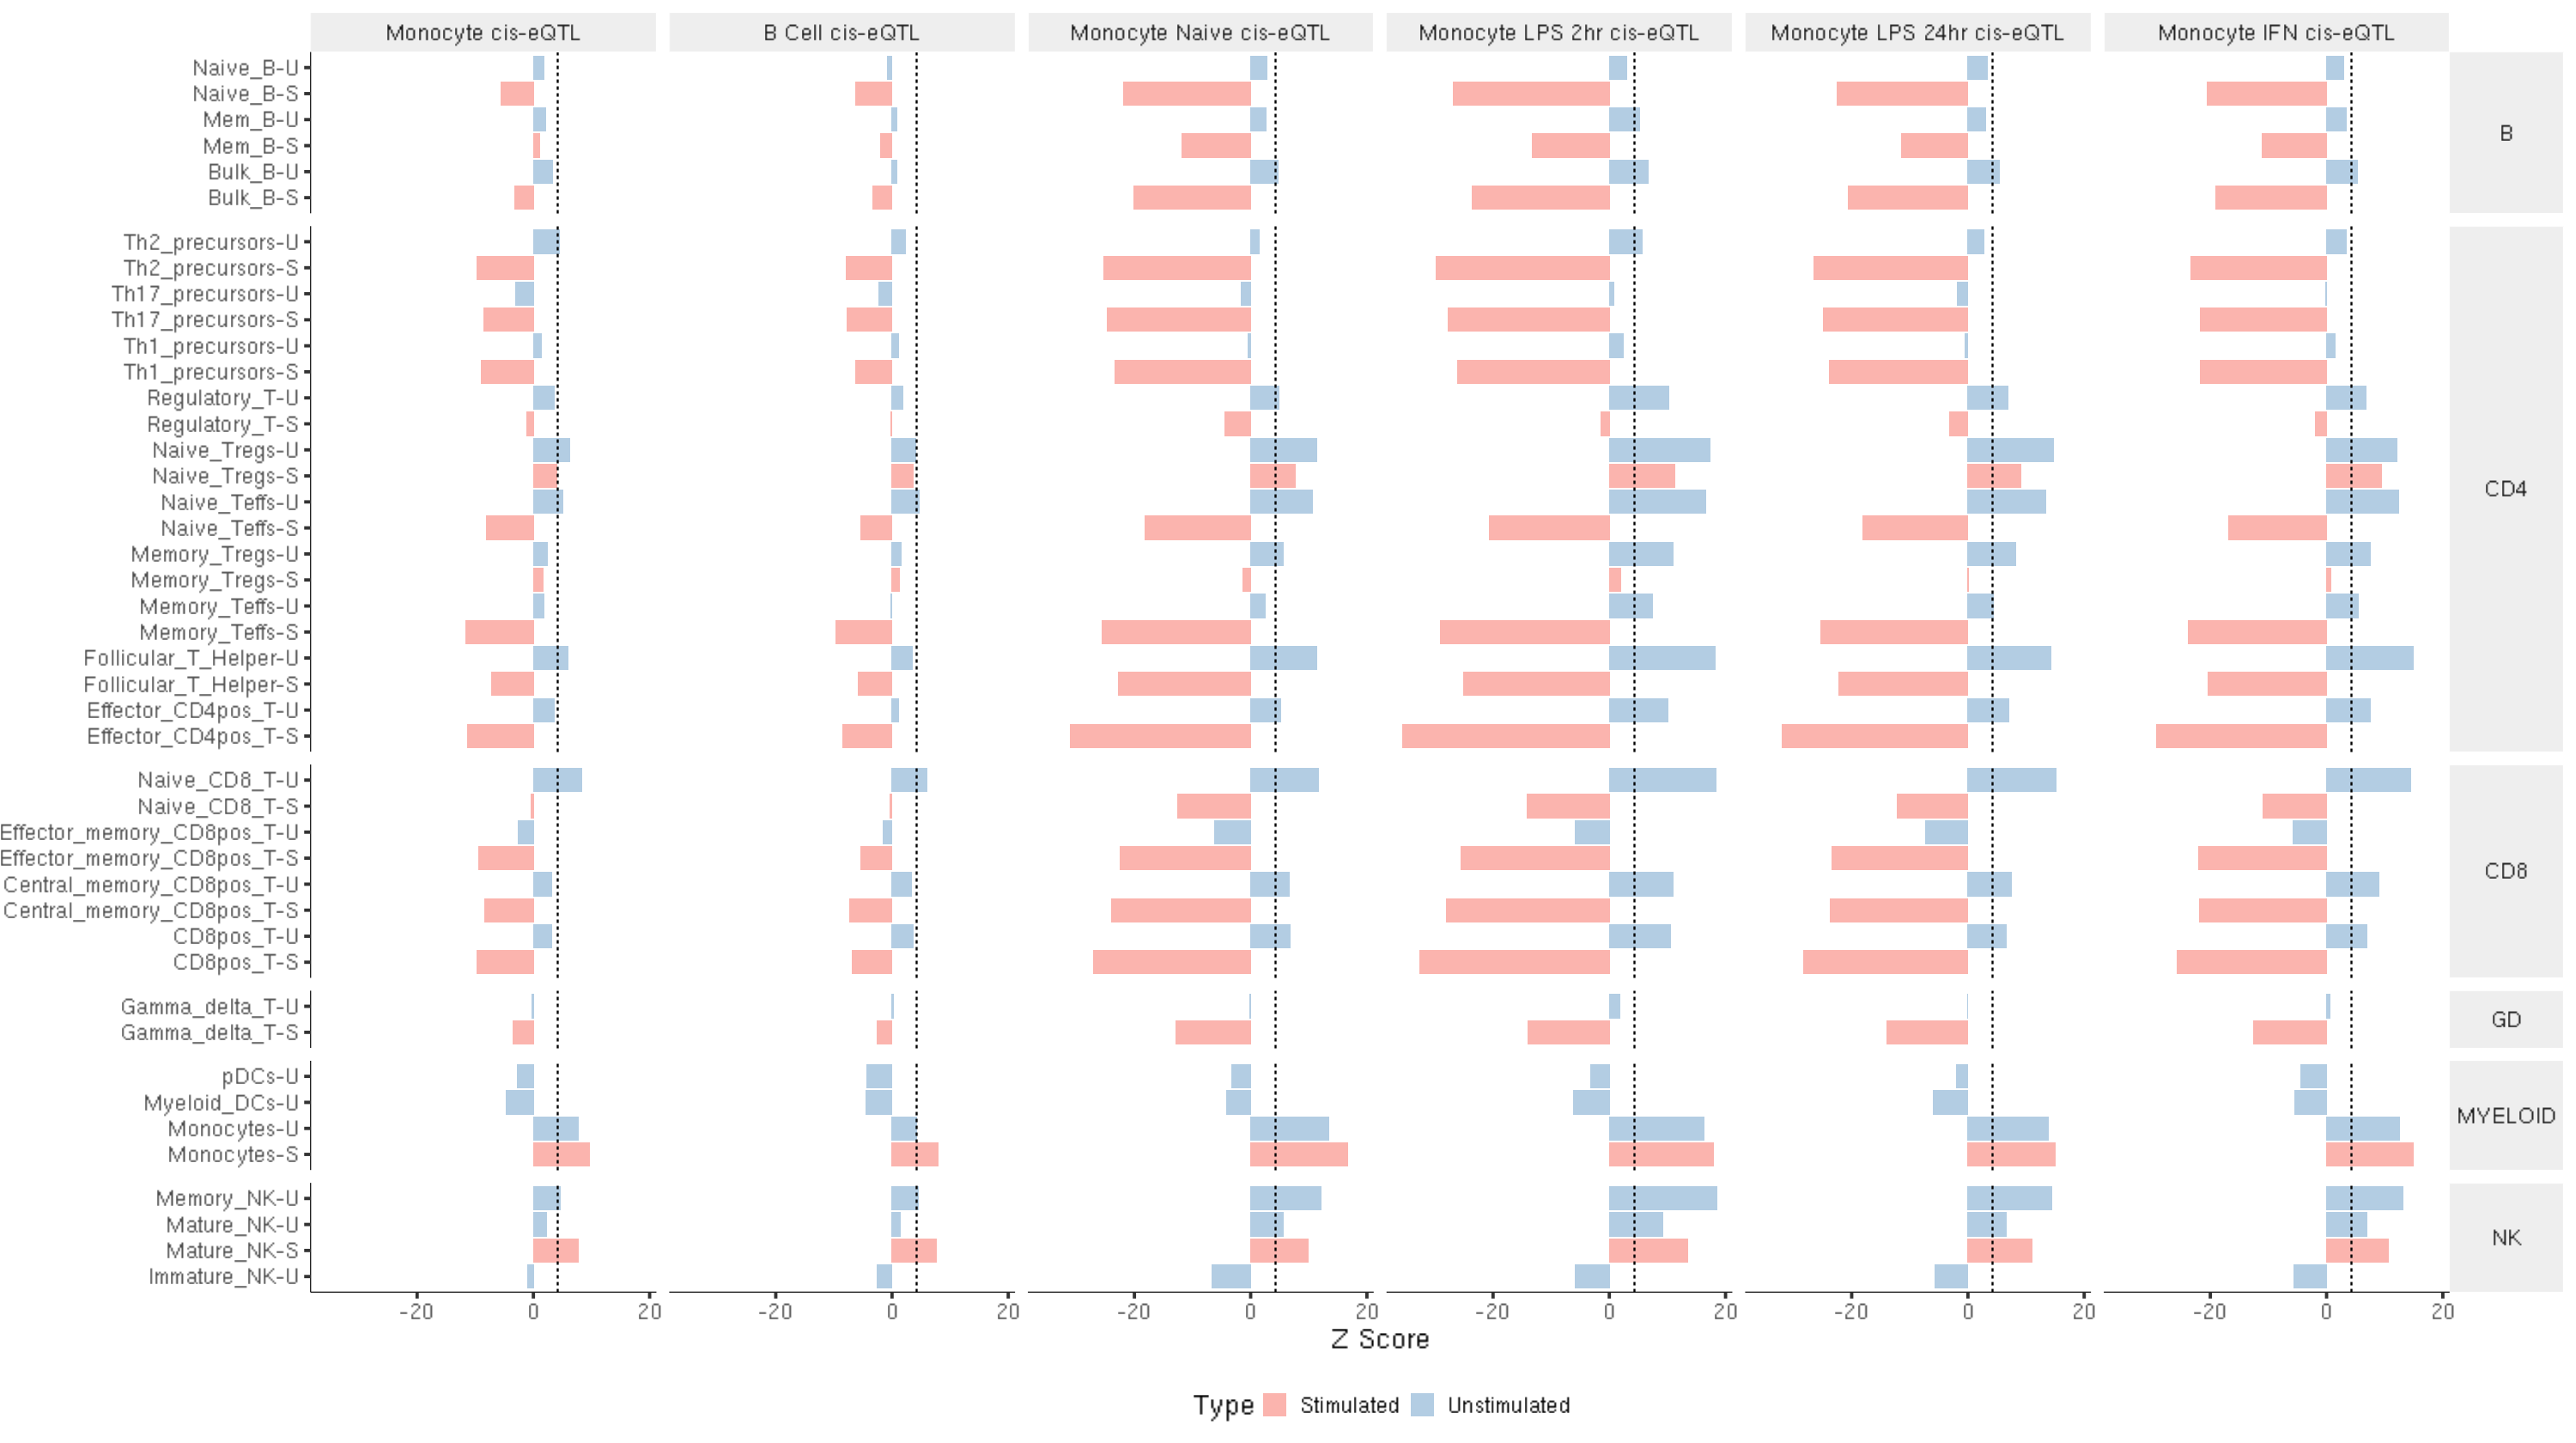

In [13]:
options(repr.plot.width=25, repr.plot.height=14)

pos.controls[["Both"]] %>%
    ggplot() + 
    geom_bar(aes(x=Condition, y=Z, fill=Type), stat="identity") +
    geom_hline(aes(yintercept=critical.value), lty=2) +
    facet_grid(Lineage ~ SNPs, scale="free_y", space="free_y") +
    scale_fill_brewer(palette="Pastel1") +
    coord_flip() +
    ylab("Z Score") +
    ggplot_theme +
    theme(axis.title.y=element_blank(), strip.text.y=element_text(angle=0))

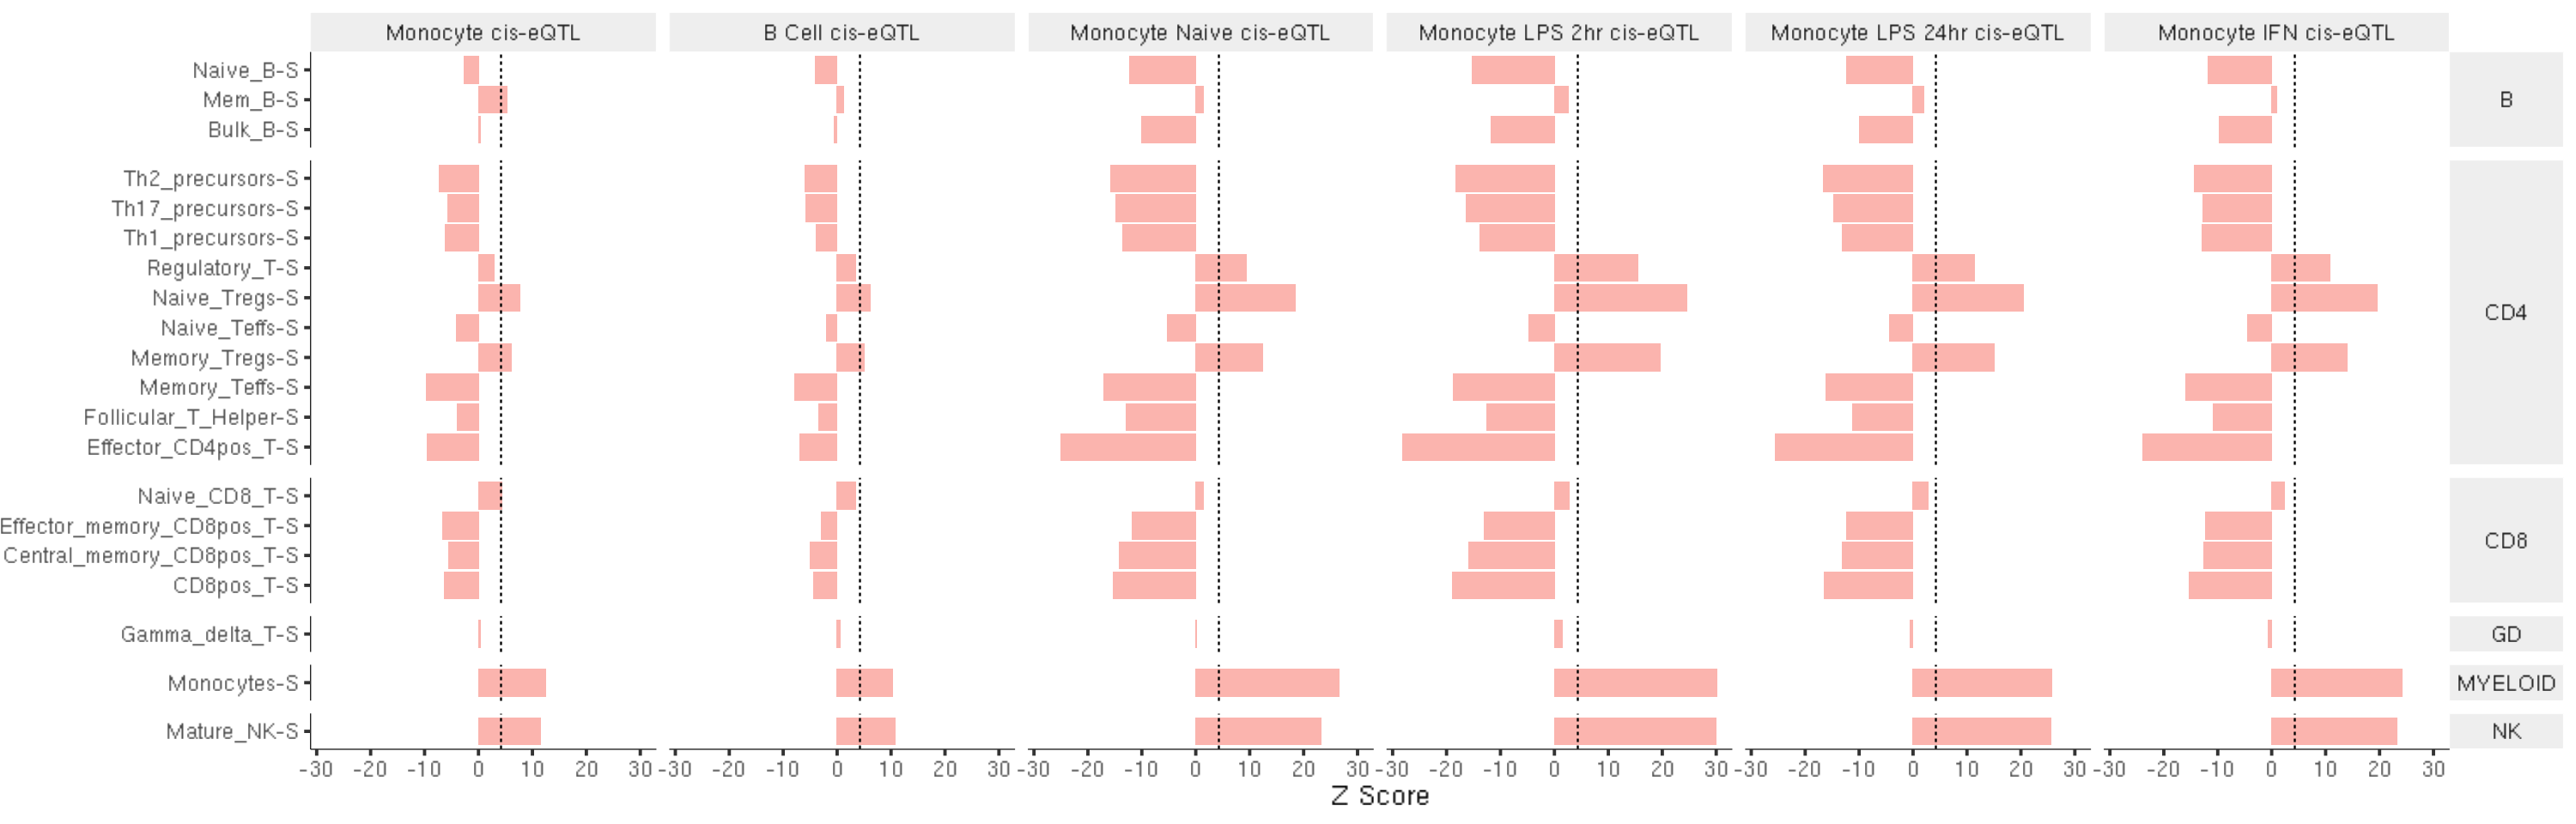

In [14]:
options(repr.plot.width=25, repr.plot.height=8)

pos.controls[["Stimulated"]] %>%
    ggplot() + 
    geom_bar(aes(x=Condition, y=Z), stat="identity", fill=RColorBrewer::brewer.pal(n=3, name="Pastel1")[1]) +
    geom_hline(aes(yintercept=critical.value), lty=2) +
    facet_grid(Lineage ~ SNPs, scale="free_y", space="free_y") +
    coord_flip() +
    ylab("Z Score") +
    ggplot_theme +
    theme(axis.title.y=element_blank(), strip.text.y=element_text(angle=0))

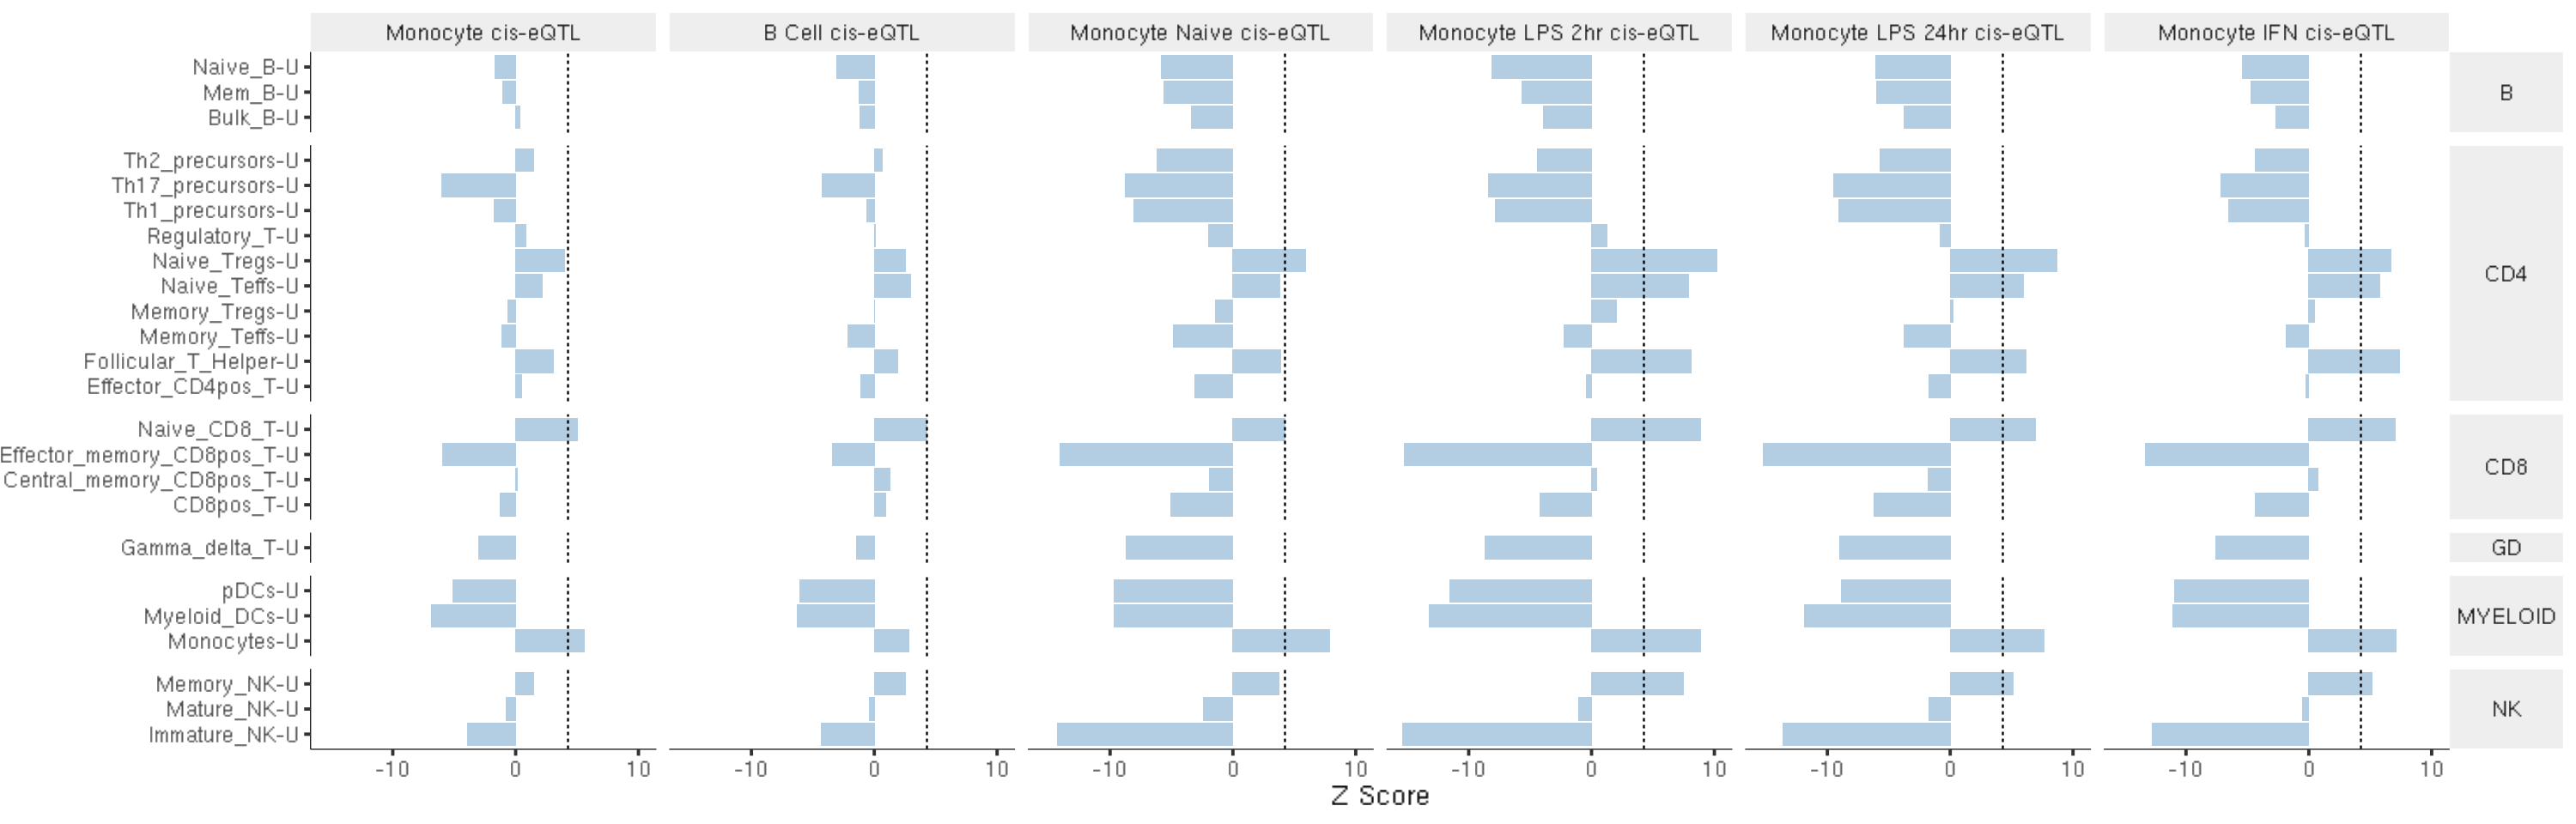

In [15]:
options(repr.plot.width=25, repr.plot.height=8)

pos.controls[["Unstimulated"]] %>%
    ggplot() + 
    geom_bar(aes(x=Condition, y=Z), stat="identity", fill=RColorBrewer::brewer.pal(n=3, name="Pastel1")[2]) +
    geom_hline(aes(yintercept=critical.value), lty=2) +
    facet_grid(Lineage ~ SNPs, scale="free_y", space="free_y") +
    coord_flip() +
    ylab("Z Score") +
    ggplot_theme +
    theme(axis.title.y=element_blank(), strip.text.y=element_text(angle=0))

## All Cell Conditions

### Load Data

In [3]:
lead.effects <- read.table(
    "~/gains_team282/epigenetics/calderon_et_al_hg19/cheers/lead_snps_disease_enrichment_observedMeanRank.txt", 
    col.names=c("Condition", "Rank.Mean")
)
conditional.effects <- read.table(
    "~/gains_team282/epigenetics/calderon_et_al_hg19/cheers/conditional_snps_disease_enrichment_observedMeanRank.txt",
    col.names=c("Condition", "Rank.Mean")
)
conditional.secondary.effects <- read.table(
    "~/gains_team282/epigenetics/calderon_et_al_hg19/cheers/conditional_secondary_snps_disease_enrichment_observedMeanRank.txt",
    col.names=c("Condition", "Rank.Mean")
)
non.sepsis.effects <- read.table(
    "~/gains_team282/epigenetics/calderon_et_al_hg19/cheers/non_sepsis_snps_disease_enrichment_observedMeanRank.txt",
    col.names=c("Condition", "Rank.Mean")
)
sepsis.effects <- read.table(
    "~/gains_team282/epigenetics/calderon_et_al_hg19/cheers/sepsis_snps_disease_enrichment_observedMeanRank.txt", 
    col.names=c("Condition", "Rank.Mean")
)
sepsis.up.effects <- read.table(
    "~/gains_team282/epigenetics/calderon_et_al_hg19/cheers/sepsis_up_snps_disease_enrichment_observedMeanRank.txt",
    col.names=c("Condition", "Rank.Mean")
)

In [4]:
lead.p.vals <- read.table("~/gains_team282/epigenetics/calderon_et_al_hg19/cheers/lead_snps_disease_enrichment_pValues.txt", col.names=c("Condition", "P.Value"))
conditional.p.vals <- read.table("~/gains_team282/epigenetics/calderon_et_al_hg19/cheers/conditional_snps_disease_enrichment_pValues.txt", col.names=c("Condition", "P.Value"))
conditional.secondary.p.vals <- read.table("~/gains_team282/epigenetics/calderon_et_al_hg19/cheers/conditional_secondary_snps_disease_enrichment_pValues.txt", col.names=c("Condition", "P.Value"))
non.sepsis.p.vals <- read.table("~/gains_team282/epigenetics/calderon_et_al_hg19/cheers/non_sepsis_snps_disease_enrichment_pValues.txt", col.names=c("Condition", "P.Value"))
sepsis.p.vals <- read.table("~/gains_team282/epigenetics/calderon_et_al_hg19/cheers/sepsis_snps_disease_enrichment_pValues.txt", col.names=c("Condition", "P.Value"))
sepsis.up.p.vals <- read.table("~/gains_team282/epigenetics/calderon_et_al_hg19/cheers/sepsis_up_snps_disease_enrichment_pValues.txt", col.names=c("Condition", "P.Value"))

In [5]:
lead.summary <- read.table("~/gains_team282/epigenetics/calderon_et_al_hg19/cheers/lead_snps.log", sep="\t")
conditional.summary <- read.table("~/gains_team282/epigenetics/calderon_et_al_hg19/cheers/conditional_snps.log", sep="\t")
conditional.secondary.summary <- read.table("~/gains_team282/epigenetics/calderon_et_al_hg19/cheers/conditional_secondary_snps.log", sep="\t")
non.sepsis.summary <- read.table("~/gains_team282/epigenetics/calderon_et_al_hg19/cheers/non_sepsis_snps.log", sep="\t")
sepsis.summary <- read.table("~/gains_team282/epigenetics/calderon_et_al_hg19/cheers/sepsis_snps.log", sep="\t")
sepsis.up.summary <- read.table("~/gains_team282/epigenetics/calderon_et_al_hg19/cheers/sepsis_up_snps.log", sep="\t")

In [6]:
lineages <- read.csv("03_Functional_Interpretation/data/Calderon_et_al_lineages.csv")

In [7]:
head(lineages)

,Lineage,Cell_Type
,<chr>,<chr>
1,B,Bulk_B
2,B,Mem_B
3,B,Naive_B
4,B,Plasmoblasts
5,CD8,CD8pos_T
6,CD8,Central_memory_CD8pos_T


The Bonferroni-adjusted significance is adjusted based on the number of samples tested against (`nrow(lead.p.vals)`), the number of SNP lists tested (6), and the number of times the testing is done (2).

In [8]:
critical.value <- qnorm(0.05 / (nrow(lead.p.vals) * 6 * 2), lower.tail=F)

In [9]:
stat.info <- data.frame(
    SNPs=c("Lead cis-eQTL", "Conditional cis-eQTL", "Conditional Secondary cis-eQTL", "Non-Sepsis-Specific cis-eQTL", "Sepsis-Specific cis-eQTL", "Sepsis-Specific Up cis-eQTL"),
    Mean=c(lead.summary[4,2], conditional.summary[4,2], conditional.secondary.summary[4,2], non.sepsis.summary[4,2], sepsis.summary[4,2], sepsis.up.summary[4,2]),
    SD=c(lead.summary[5,2], conditional.summary[5,2], conditional.secondary.summary[5,2], non.sepsis.summary[5,2], sepsis.summary[5,2], sepsis.up.summary[5,2])
)

head(stat.info)

,SNPs,Mean,SD
,<chr>,<dbl>,<dbl>
1,Lead cis-eQTL,361495.5,3764.960
2,Conditional cis-eQTL,361495.5,3126.577
3,Conditional Secondary cis-eQTL,361495.5,5330.532
4,Non-Sepsis-Specific cis-eQTL,361495.5,4237.369
5,Sepsis-Specific cis-eQTL,361495.5,8069.165
6,Sepsis-Specific Up cis-eQTL,361495.5,12517.548


In [10]:
effects <- dplyr::bind_rows(
    lead.effects %>% dplyr::mutate(SNPs="Lead cis-eQTL"),
    conditional.effects %>% dplyr::mutate(SNPs="Conditional cis-eQTL"),
    conditional.secondary.effects %>% dplyr::mutate(SNPs="Conditional Secondary cis-eQTL"),
    non.sepsis.effects %>% dplyr::mutate(SNPs="Non-Sepsis-Specific cis-eQTL"),
    sepsis.effects %>% dplyr::mutate(SNPs="Sepsis-Specific cis-eQTL"),
    sepsis.up.effects %>% dplyr::mutate(SNPs="Sepsis-Specific Up cis-eQTL")
)

head(effects)

,Condition,Rank.Mean,SNPs
,<chr>,<dbl>,<chr>
1,Bulk_B-S,302656.1,Lead cis-eQTL
2,Bulk_B-U,374670.1,Lead cis-eQTL
3,CD8pos_T-S,276170.9,Lead cis-eQTL
4,CD8pos_T-U,386817.6,Lead cis-eQTL
5,Central_memory_CD8pos_T-S,288349.9,Lead cis-eQTL
6,Central_memory_CD8pos_T-U,385296.0,Lead cis-eQTL


In [11]:
p.vals <- dplyr::bind_rows(
    lead.p.vals %>% dplyr::mutate(SNPs="Lead cis-eQTL"),
    conditional.p.vals %>% dplyr::mutate(SNPs="Conditional cis-eQTL"),
    conditional.secondary.p.vals %>% dplyr::mutate(SNPs="Conditional Secondary cis-eQTL"),
    non.sepsis.p.vals %>% dplyr::mutate(SNPs="Non-Sepsis-Specific cis-eQTL"),
    sepsis.p.vals %>% dplyr::mutate(SNPs="Sepsis-Specific cis-eQTL"),
    sepsis.up.p.vals %>% dplyr::mutate(SNPs="Sepsis-Specific Up cis-eQTL")
)

head(p.vals)

,Condition,P.Value,SNPs
,<chr>,<dbl>,<chr>
1,Bulk_B-S,1.000000e+00,Lead cis-eQTL
2,Bulk_B-U,2.332797e-04,Lead cis-eQTL
3,CD8pos_T-S,1.000000e+00,Lead cis-eQTL
4,CD8pos_T-U,8.735346e-12,Lead cis-eQTL
5,Central_memory_CD8pos_T-S,1.000000e+00,Lead cis-eQTL
6,Central_memory_CD8pos_T-U,1.294572e-10,Lead cis-eQTL


### Enrichment of Different SNP Lists

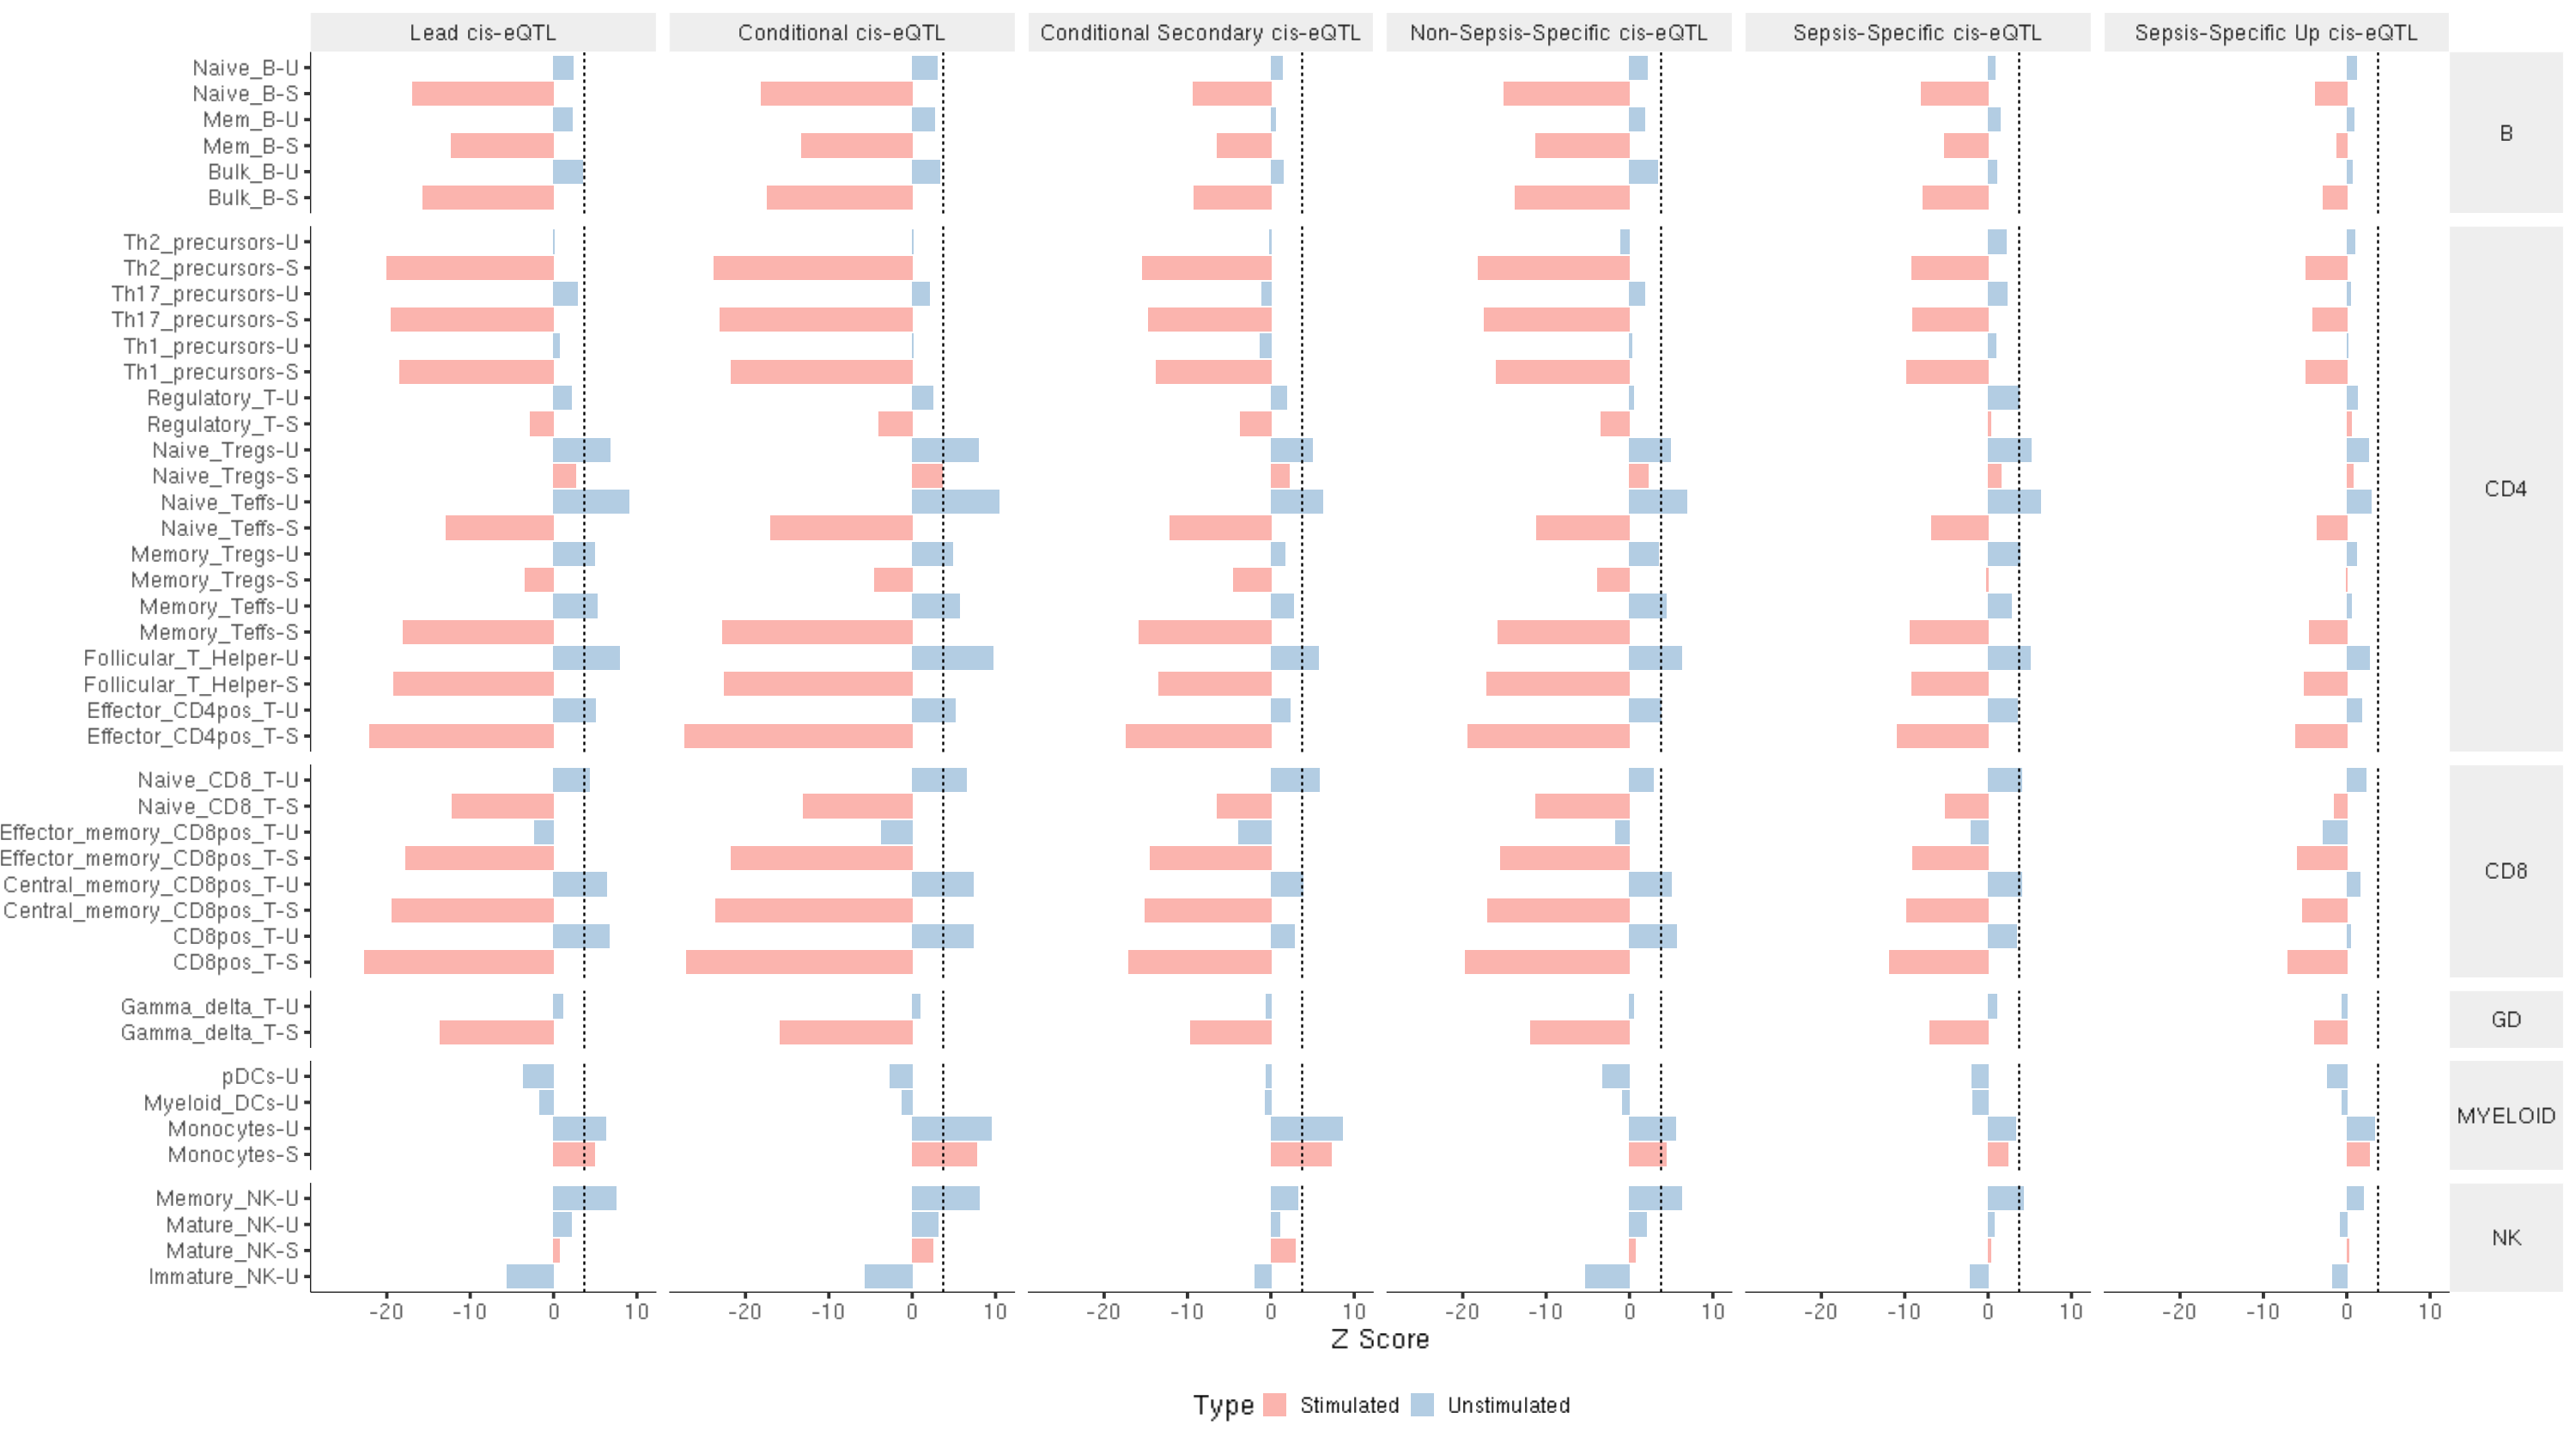

In [12]:
options(repr.plot.width=25, repr.plot.height=14)

merge(effects, p.vals, by=c("SNPs", "Condition")) %>%
    merge(., stat.info, by="SNPs") %>%
    dplyr::mutate(SNPs=factor(SNPs, levels=c("Lead cis-eQTL", "Conditional cis-eQTL", "Conditional Secondary cis-eQTL", "Non-Sepsis-Specific cis-eQTL", "Sepsis-Specific cis-eQTL", "Sepsis-Specific Up cis-eQTL"))) %>%
    dplyr::mutate(Z=(Rank.Mean - Mean) / SD) %>%
    dplyr::mutate(Cell_Type=gsub("-[SU]$", "", Condition)) %>%
    merge(., lineages, by="Cell_Type") %>%
    dplyr::mutate(Type=ifelse(grepl("-S$", Condition), "Stimulated", "Unstimulated")) %>%
    ggplot() + 
    geom_bar(aes(x=Condition, y=Z, fill=Type), stat="identity") +
    geom_hline(aes(yintercept=critical.value), lty=2) +
    facet_grid(Lineage ~ SNPs, scale="free_y", space="free_y") +
    scale_fill_brewer(palette="Pastel1") +
    coord_flip() +
    ylab("Z Score") +
    ggplot_theme +
    theme(axis.title.y=element_blank(), strip.text.y=element_text(angle=0))

ggsave("03_Functional_Interpretation/results/cheers_hg19_calderon_et_al_all.svg", width=25, height=14)

### Signal Association with ATAC-Seq Sample Quality

Since the pattern is repeated across various SNP lists, the sample quality of the ATAC-Seq samples may make it more likely for certain associations to come through because more peaks are being detected in those samples. Indeed, in my own processing of the data, I have noticed that sample quality is associated with specific cell types.

In [13]:
sample.qc <- readxl::read_xlsx("03_Functional_Interpretation/data/41588_2019_505_MOESM3_ESM.xlsx", sheet="ATAC-seq samle QC") %>%
    dplyr::mutate(condition=paste0(cell_type, "-", condition))

In [14]:
head(sample.qc)

sample,n_peaks,merged_final_read_count,tss_enrichment,donor,cell_type,condition
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
1001-Bulk_B-S,99921,89133710,22.60328,1001,Bulk_B,Bulk_B-S
1001-Bulk_B-U,89186,75096300,21.60695,1001,Bulk_B,Bulk_B-U
1001-CD8pos_T-S,99319,79127056,19.86049,1001,CD8pos_T,CD8pos_T-S
1001-CD8pos_T-U,79809,83412526,21.93009,1001,CD8pos_T,CD8pos_T-U
1001-Central_memory_CD8pos_T-S,100868,56264624,18.59552,1001,Central_memory_CD8pos_T,Central_memory_CD8pos_T-S
1001-Central_memory_CD8pos_T-U,72386,54006014,22.54937,1001,Central_memory_CD8pos_T,Central_memory_CD8pos_T-U


`geom_smooth()` using formula 'y ~ x'



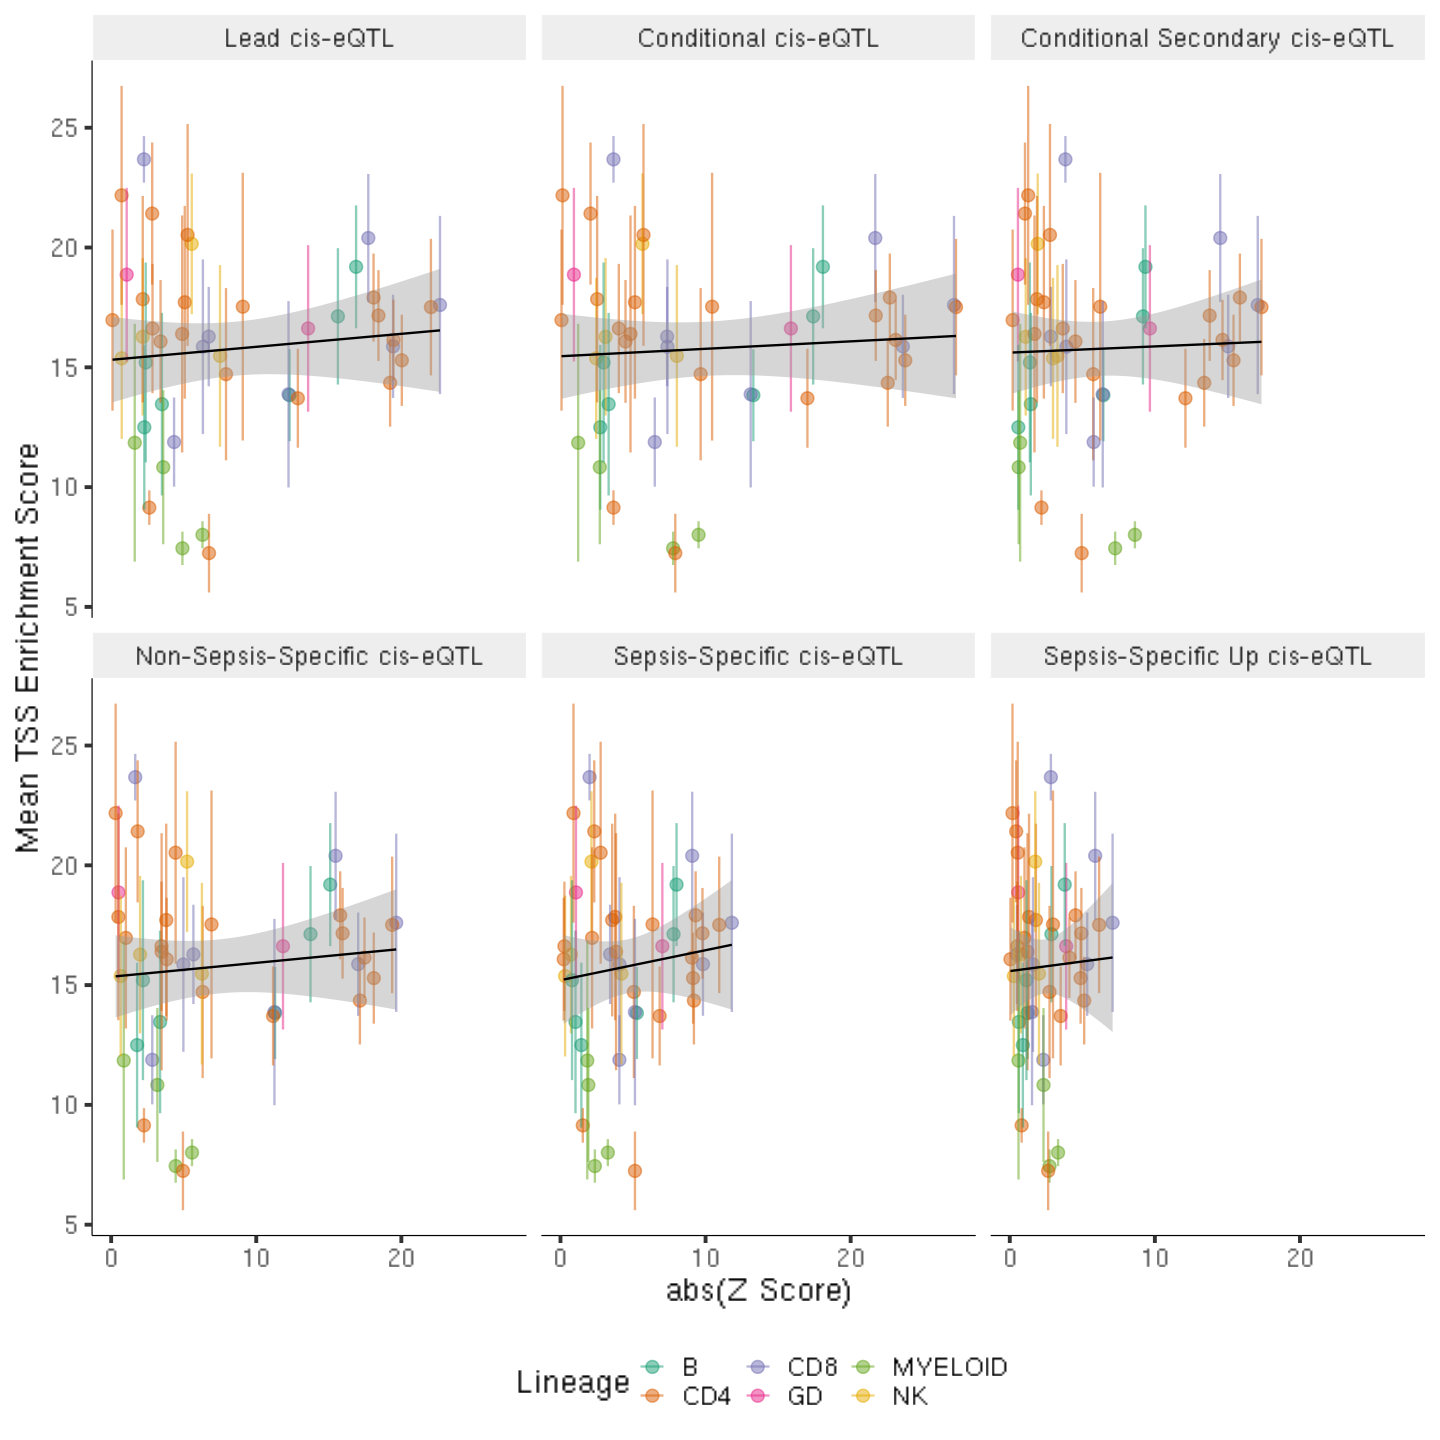

In [15]:
options(repr.plot.width=12, repr.plot.height=12)

merge(effects, p.vals, by=c("SNPs", "Condition")) %>%
    merge(., stat.info, by="SNPs") %>%
    dplyr::mutate(SNPs=factor(SNPs, levels=c("Lead cis-eQTL", "Conditional cis-eQTL", "Conditional Secondary cis-eQTL", "Non-Sepsis-Specific cis-eQTL", "Sepsis-Specific cis-eQTL", "Sepsis-Specific Up cis-eQTL"))) %>%
    dplyr::mutate(Z=abs((Rank.Mean - Mean) / SD)) %>%
    dplyr::mutate(Cell_Type=gsub("-[SU]$", "", Condition)) %>%
    merge(., lineages, by="Cell_Type") %>%
    merge(., sample.qc, by.x="Condition", by.y="condition") %>%
    dplyr::group_by(SNPs, Condition) %>%
    dplyr::summarize(Lineage=Lineage[1], Cell_Type=Cell_Type[1], Z=Z[1], Mean.TSS.Enrichment=mean(tss_enrichment), SE.TSS.Enrichment=sd(tss_enrichment) / sqrt(n()), .groups="drop") %>%
    dplyr::mutate(SE.Low=Mean.TSS.Enrichment - SE.TSS.Enrichment, SE.High=Mean.TSS.Enrichment + SE.TSS.Enrichment) %>%
    ggplot() +
    geom_point(aes(x=Z, y=Mean.TSS.Enrichment, color=Lineage), size=3, alpha=0.5) +
    geom_errorbar(aes(x=Z, ymin=SE.Low, ymax=SE.High, color=Lineage), alpha=0.5) +
    geom_smooth(aes(x=Z, y=Mean.TSS.Enrichment), method="lm", size=0.5, color="black") +
    facet_wrap(. ~ SNPs) +
    scale_color_brewer(palette="Dark2") +
    xlab("abs(Z Score)") + ylab("Mean TSS Enrichment Score") +
    ggplot_theme

## Stimulated Cell Conditions

### Load Data from Stimulated Cell Types

In [16]:
lead.effects <- read.table(
    "~/gains_team282/epigenetics/calderon_et_al_hg19/cheers/lead_snps_stimulated_disease_enrichment_observedMeanRank.txt", 
    col.names=c("Condition", "Rank.Mean")
)
conditional.effects <- read.table(
    "~/gains_team282/epigenetics/calderon_et_al_hg19/cheers/conditional_snps_stimulated_disease_enrichment_observedMeanRank.txt",
    col.names=c("Condition", "Rank.Mean")
)
conditional.secondary.effects <- read.table(
    "~/gains_team282/epigenetics/calderon_et_al_hg19/cheers/conditional_secondary_snps_stimulated_disease_enrichment_observedMeanRank.txt",
    col.names=c("Condition", "Rank.Mean")
)
non.sepsis.effects <- read.table(
    "~/gains_team282/epigenetics/calderon_et_al_hg19/cheers/non_sepsis_snps_stimulated_disease_enrichment_observedMeanRank.txt",
    col.names=c("Condition", "Rank.Mean")
)
sepsis.effects <- read.table(
    "~/gains_team282/epigenetics/calderon_et_al_hg19/cheers/sepsis_snps_stimulated_disease_enrichment_observedMeanRank.txt", 
    col.names=c("Condition", "Rank.Mean")
)
sepsis.up.effects <- read.table(
    "~/gains_team282/epigenetics/calderon_et_al_hg19/cheers/sepsis_up_snps_stimulated_disease_enrichment_observedMeanRank.txt",
    col.names=c("Condition", "Rank.Mean")
)

In [17]:
lead.p.vals <- read.table("~/gains_team282/epigenetics/calderon_et_al_hg19/cheers/lead_snps_stimulated_disease_enrichment_pValues.txt", col.names=c("Condition", "P.Value"))
conditional.p.vals <- read.table("~/gains_team282/epigenetics/calderon_et_al_hg19/cheers/conditional_snps_stimulated_disease_enrichment_pValues.txt", col.names=c("Condition", "P.Value"))
conditional.secondary.p.vals <- read.table("~/gains_team282/epigenetics/calderon_et_al_hg19/cheers/conditional_secondary_snps_stimulated_disease_enrichment_pValues.txt", col.names=c("Condition", "P.Value"))
non.sepsis.p.vals <- read.table("~/gains_team282/epigenetics/calderon_et_al_hg19/cheers/non_sepsis_snps_stimulated_disease_enrichment_pValues.txt", col.names=c("Condition", "P.Value"))
sepsis.p.vals <- read.table("~/gains_team282/epigenetics/calderon_et_al_hg19/cheers/sepsis_snps_stimulated_disease_enrichment_pValues.txt", col.names=c("Condition", "P.Value"))
sepsis.up.p.vals <- read.table("~/gains_team282/epigenetics/calderon_et_al_hg19/cheers/sepsis_up_snps_stimulated_disease_enrichment_pValues.txt", col.names=c("Condition", "P.Value"))

In [18]:
lead.summary <- read.table("~/gains_team282/epigenetics/calderon_et_al_hg19/cheers/lead_snps_stimulated.log", sep="\t")
conditional.summary <- read.table("~/gains_team282/epigenetics/calderon_et_al_hg19/cheers/conditional_snps_stimulated.log", sep="\t")
conditional.secondary.summary <- read.table("~/gains_team282/epigenetics/calderon_et_al_hg19/cheers/conditional_secondary_snps_stimulated.log", sep="\t")
non.sepsis.summary <- read.table("~/gains_team282/epigenetics/calderon_et_al_hg19/cheers/non_sepsis_snps_stimulated.log", sep="\t")
sepsis.summary <- read.table("~/gains_team282/epigenetics/calderon_et_al_hg19/cheers/sepsis_snps_stimulated.log", sep="\t")
sepsis.up.summary <- read.table("~/gains_team282/epigenetics/calderon_et_al_hg19/cheers/sepsis_up_snps_stimulated.log", sep="\t")

In [19]:
stat.info <- data.frame(
    SNPs=c("Lead cis-eQTL", "Conditional cis-eQTL", "Conditional Secondary cis-eQTL", "Non-Sepsis-Specific cis-eQTL", "Sepsis-Specific cis-eQTL", "Sepsis-Specific Up cis-eQTL"),
    Mean=c(lead.summary[4,2], conditional.summary[4,2], conditional.secondary.summary[4,2], non.sepsis.summary[4,2], sepsis.summary[4,2], sepsis.up.summary[4,2]),
    SD=c(lead.summary[5,2], conditional.summary[5,2], conditional.secondary.summary[5,2], non.sepsis.summary[5,2], sepsis.summary[5,2], sepsis.up.summary[5,2])
)

head(stat.info)

,SNPs,Mean,SD
,<chr>,<dbl>,<dbl>
1,Lead cis-eQTL,361495.5,3774.183
2,Conditional cis-eQTL,361495.5,3133.970
3,Conditional Secondary cis-eQTL,361495.5,5344.496
4,Non-Sepsis-Specific cis-eQTL,361495.5,4249.648
5,Sepsis-Specific cis-eQTL,361495.5,8075.203
6,Sepsis-Specific Up cis-eQTL,361495.5,12495.095


In [20]:
effects <- dplyr::bind_rows(
    lead.effects %>% dplyr::mutate(SNPs="Lead cis-eQTL"),
    conditional.effects %>% dplyr::mutate(SNPs="Conditional cis-eQTL"),
    conditional.secondary.effects %>% dplyr::mutate(SNPs="Conditional Secondary cis-eQTL"),
    non.sepsis.effects %>% dplyr::mutate(SNPs="Non-Sepsis-Specific cis-eQTL"),
    sepsis.effects %>% dplyr::mutate(SNPs="Sepsis-Specific cis-eQTL"),
    sepsis.up.effects %>% dplyr::mutate(SNPs="Sepsis-Specific Up cis-eQTL")
)

head(effects)

,Condition,Rank.Mean,SNPs
,<chr>,<dbl>,<chr>
1,Bulk_B-S,336538.2,Lead cis-eQTL
2,CD8pos_T-S,312711.5,Lead cis-eQTL
3,Central_memory_CD8pos_T-S,320174.7,Lead cis-eQTL
4,Effector_CD4pos_T-S,301673.5,Lead cis-eQTL
5,Effector_memory_CD8pos_T-S,328587.4,Lead cis-eQTL
6,Follicular_T_Helper-S,323096.0,Lead cis-eQTL


In [21]:
p.vals <- dplyr::bind_rows(
    lead.p.vals %>% dplyr::mutate(SNPs="Lead cis-eQTL"),
    conditional.p.vals %>% dplyr::mutate(SNPs="Conditional cis-eQTL"),
    conditional.secondary.p.vals %>% dplyr::mutate(SNPs="Conditional Secondary cis-eQTL"),
    non.sepsis.p.vals %>% dplyr::mutate(SNPs="Non-Sepsis-Specific cis-eQTL"),
    sepsis.p.vals %>% dplyr::mutate(SNPs="Sepsis-Specific cis-eQTL"),
    sepsis.up.p.vals %>% dplyr::mutate(SNPs="Sepsis-Specific Up cis-eQTL")
)

head(p.vals)

,Condition,P.Value,SNPs
,<chr>,<dbl>,<chr>
1,Bulk_B-S,1,Lead cis-eQTL
2,CD8pos_T-S,1,Lead cis-eQTL
3,Central_memory_CD8pos_T-S,1,Lead cis-eQTL
4,Effector_CD4pos_T-S,1,Lead cis-eQTL
5,Effector_memory_CD8pos_T-S,1,Lead cis-eQTL
6,Follicular_T_Helper-S,1,Lead cis-eQTL


### Enrichment of Different SNP Lists

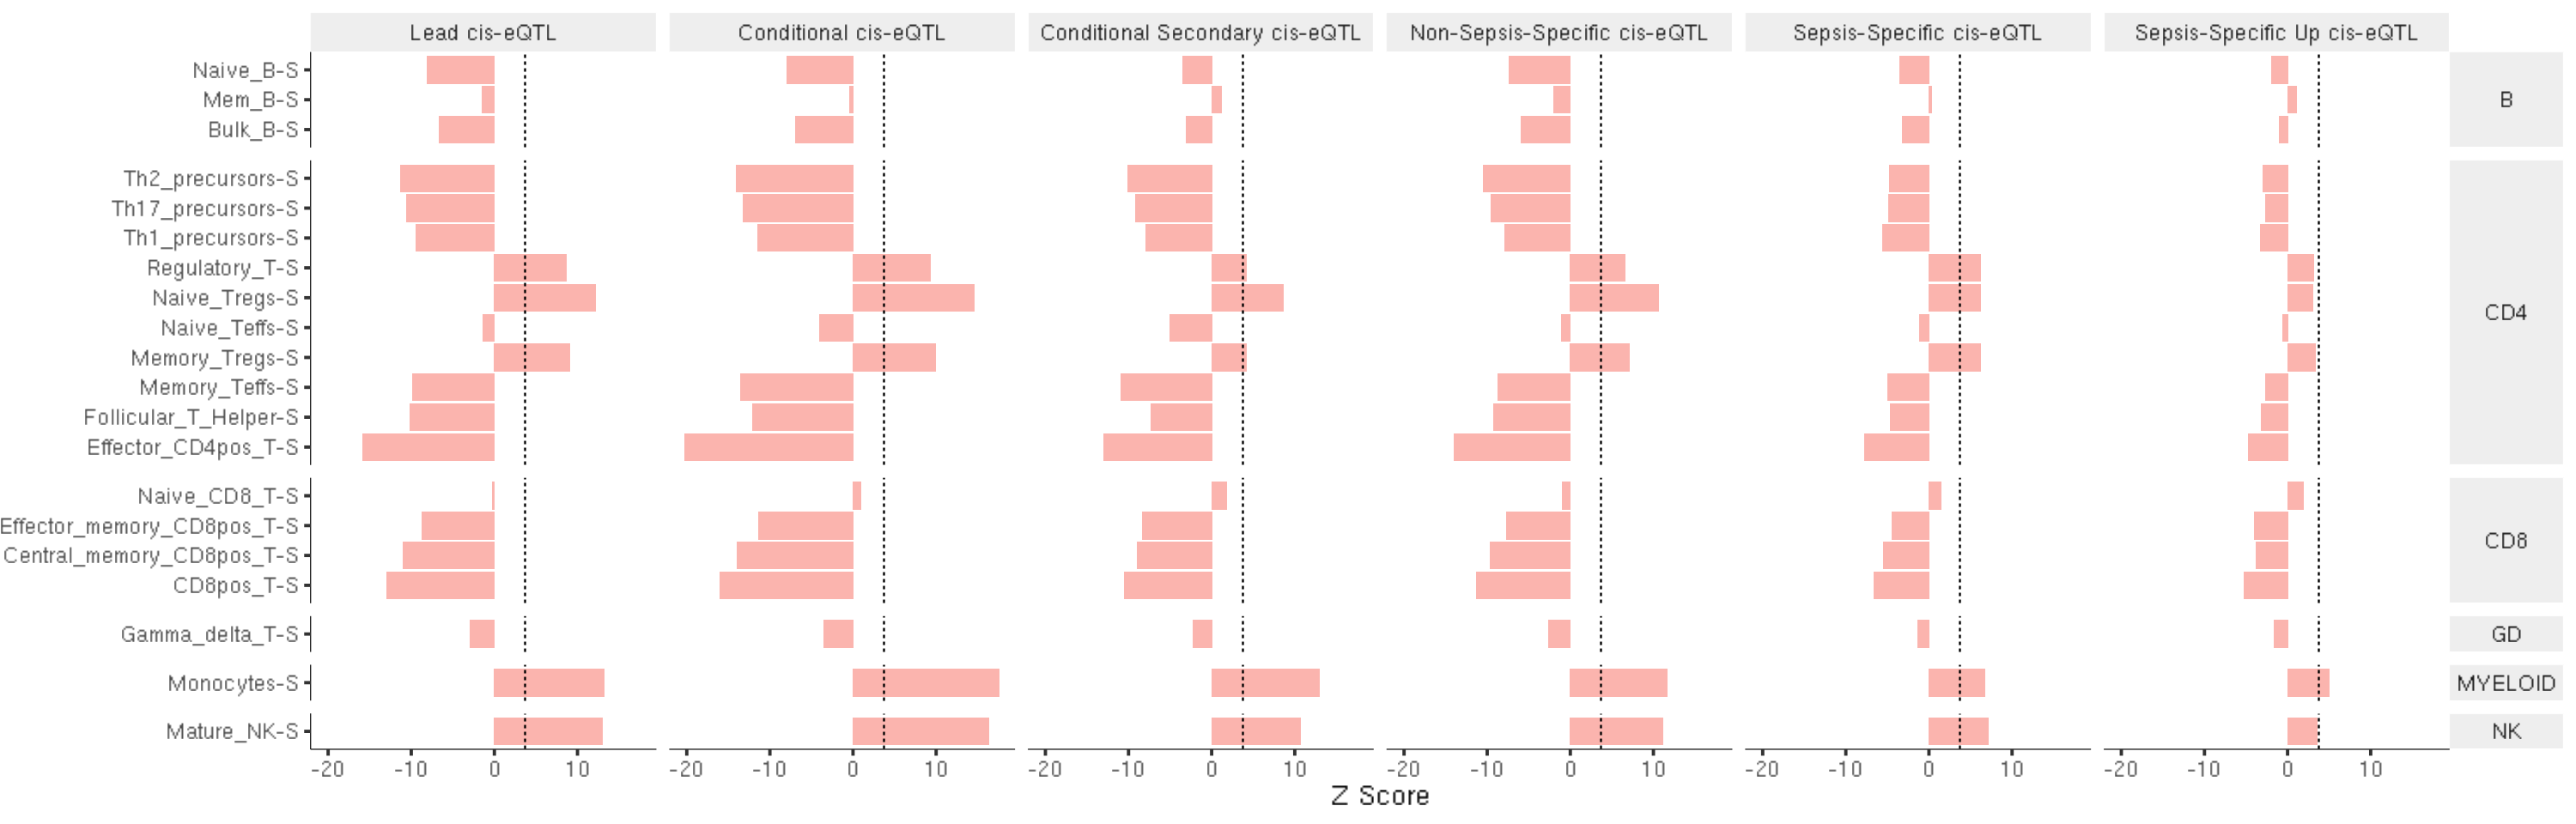

In [22]:
options(repr.plot.width=25, repr.plot.height=8)

merge(effects, p.vals, by=c("SNPs", "Condition")) %>%
    merge(., stat.info, by="SNPs") %>%
    dplyr::mutate(SNPs=factor(SNPs, levels=c("Lead cis-eQTL", "Conditional cis-eQTL", "Conditional Secondary cis-eQTL", "Non-Sepsis-Specific cis-eQTL", "Sepsis-Specific cis-eQTL", "Sepsis-Specific Up cis-eQTL"))) %>%
    dplyr::mutate(Z=(Rank.Mean - Mean) / SD) %>%
    dplyr::mutate(Cell_Type=gsub("-[SU]$", "", Condition)) %>%
    merge(., lineages, by="Cell_Type") %>%
    ggplot() + 
    geom_bar(aes(x=Condition, y=Z), stat="identity", fill=RColorBrewer::brewer.pal(n=3, name="Pastel1")[1]) +
    geom_hline(aes(yintercept=critical.value), lty=2) +
    facet_grid(Lineage ~ SNPs, scale="free_y", space="free_y") +
    coord_flip() +
    ylab("Z Score") +
    ggplot_theme +
    theme(axis.title.y=element_blank(), strip.text.y=element_text(angle=0))

ggsave("03_Functional_Interpretation/results/cheers_hg19_calderon_et_al_stimulated_all.svg", width=25, height=8)

### Enrichment of Secondary cis-eQTL

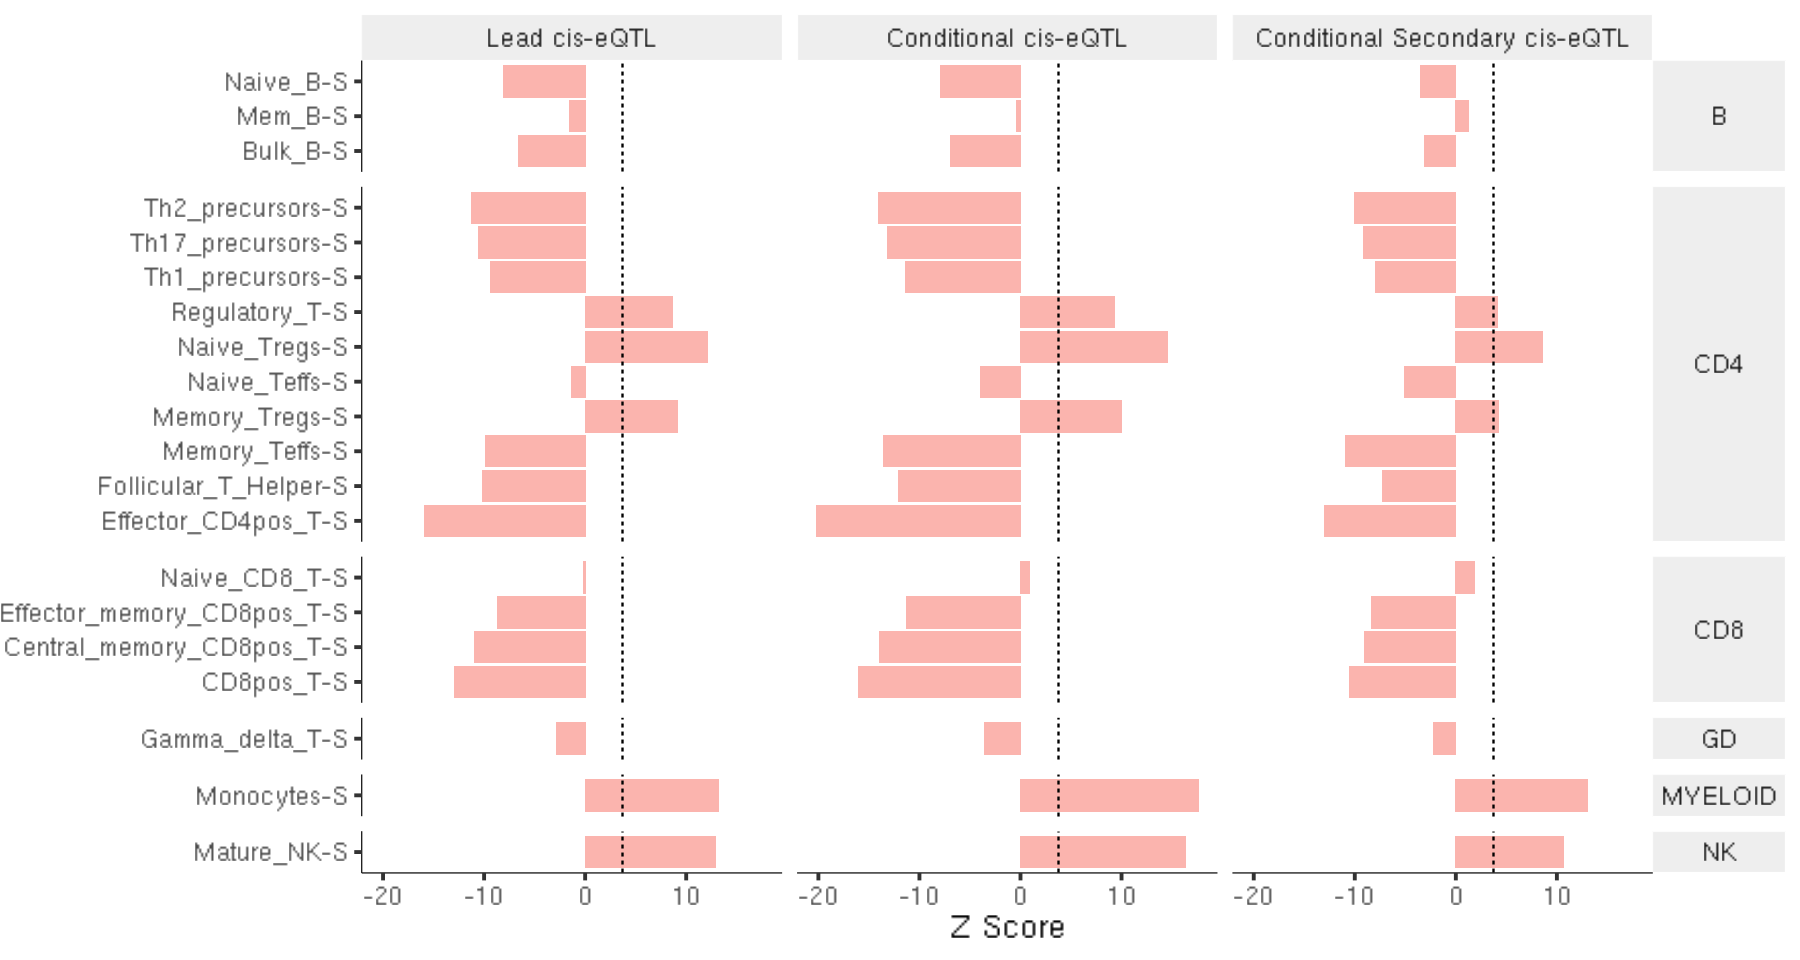

In [23]:
options(repr.plot.width=15, repr.plot.height=8)

merge(effects, p.vals, by=c("SNPs", "Condition")) %>%
    merge(., stat.info, by="SNPs") %>%
    dplyr::mutate(SNPs=factor(SNPs, levels=c("Lead cis-eQTL", "Conditional cis-eQTL", "Conditional Secondary cis-eQTL"))) %>%
    dplyr::filter(SNPs %in% c("Lead cis-eQTL", "Conditional cis-eQTL", "Conditional Secondary cis-eQTL")) %>%
    dplyr::mutate(Z=(Rank.Mean - Mean) / SD) %>%
    dplyr::mutate(Cell_Type=gsub("-[SU]$", "", Condition)) %>%
    merge(., lineages, by="Cell_Type") %>%
    ggplot() + 
    geom_bar(aes(x=Condition, y=Z), stat="identity", fill=RColorBrewer::brewer.pal(n=3, name="Pastel1")[1]) +
    geom_hline(aes(yintercept=critical.value), lty=2) +
    facet_grid(Lineage ~ SNPs, scale="free_y", space="free_y") +
    coord_flip() +
    ylab("Z Score") +
    ggplot_theme +
    theme(axis.title.y=element_blank(), strip.text.y=element_text(angle=0))

ggsave("03_Functional_Interpretation/results/cheers_hg19_calderon_et_al_stimulated_secondary_signals.svg", width=15, height=8)

### Enrichment of Sepsis-Specific cis-eQTL

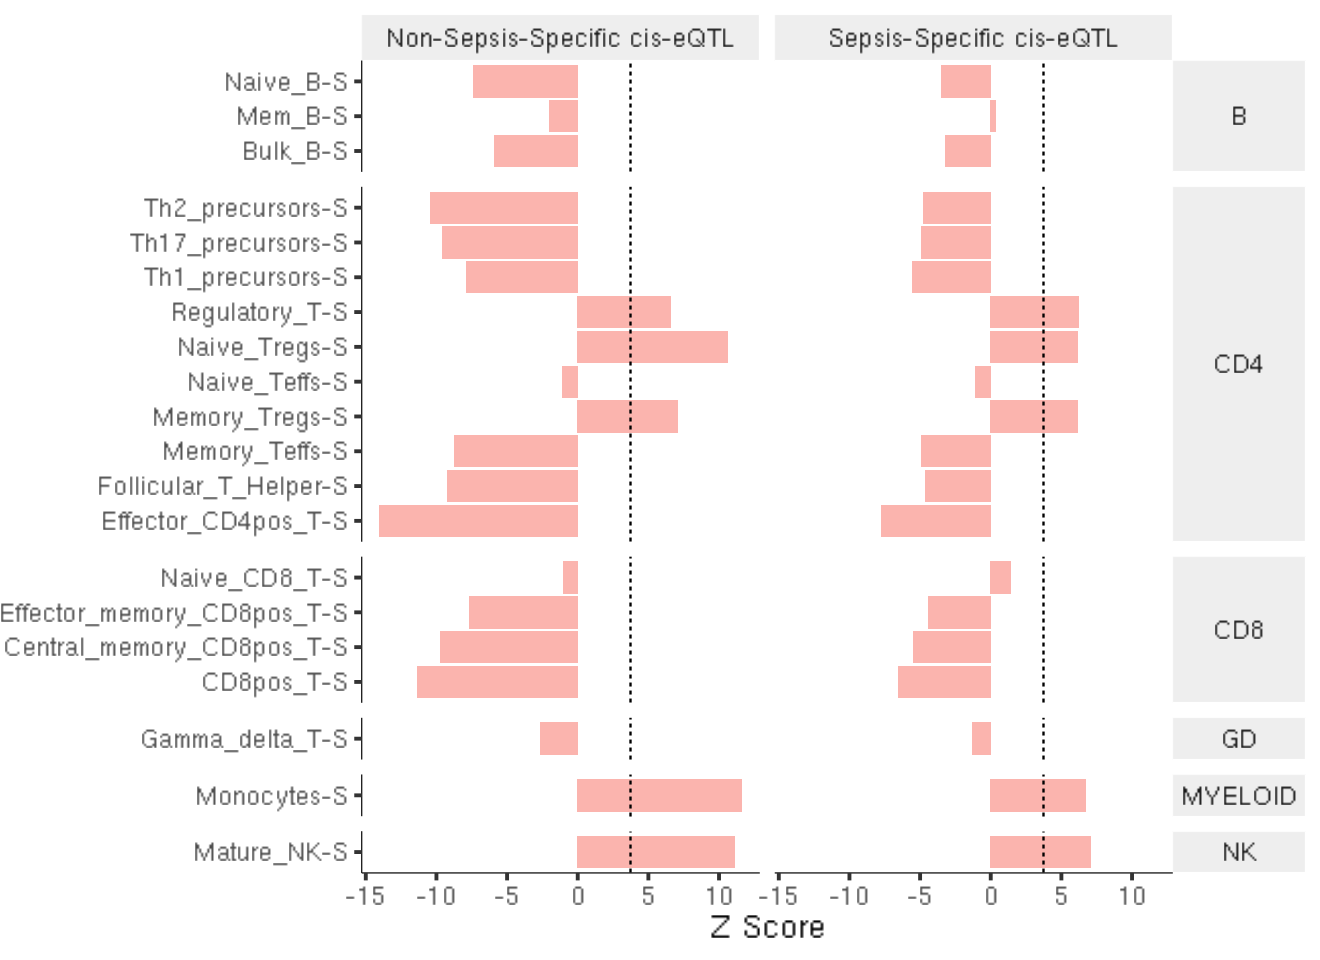

In [24]:
options(repr.plot.width=11, repr.plot.height=8)

merge(effects, p.vals, by=c("SNPs", "Condition")) %>%
    merge(., stat.info, by="SNPs") %>%
    dplyr::filter(SNPs %in% c("Sepsis-Specific cis-eQTL", "Non-Sepsis-Specific cis-eQTL")) %>%
    dplyr::mutate(Z=(Rank.Mean - Mean) / SD) %>%
    dplyr::mutate(Cell_Type=gsub("-[SU]$", "", Condition)) %>%
    merge(., lineages, by="Cell_Type") %>%
    ggplot() + 
    geom_bar(aes(x=Condition, y=Z), stat="identity", fill=RColorBrewer::brewer.pal(n=3, name="Pastel1")[1]) +
    geom_hline(aes(yintercept=critical.value), lty=2) +
    facet_grid(Lineage ~ SNPs, scale="free_y", space="free_y") +
    coord_flip() +
    ylab("Z Score") +
    ggplot_theme +
    theme(axis.title.y=element_blank(), strip.text.y=element_text(angle=0))

ggsave("03_Functional_Interpretation/results/cheers_hg19_calderon_et_al_stimulated_sepsis_specific.svg", width=11, height=8)

### Signal Association with ATAC-Seq Sample Quality

Since the pattern is repeated across various SNP lists, the sample quality of the ATAC-Seq samples may make it more likely for certain associations to come through because more peaks are being detected in those samples. Indeed, in my own processing of the data, I have noticed that sample quality is associated with specific cell types.

In [25]:
sample.qc <- readxl::read_xlsx("03_Functional_Interpretation/data/41588_2019_505_MOESM3_ESM.xlsx", sheet="ATAC-seq samle QC") %>%
    dplyr::mutate(condition=paste0(cell_type, "-", condition))

In [26]:
head(sample.qc)

sample,n_peaks,merged_final_read_count,tss_enrichment,donor,cell_type,condition
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
1001-Bulk_B-S,99921,89133710,22.60328,1001,Bulk_B,Bulk_B-S
1001-Bulk_B-U,89186,75096300,21.60695,1001,Bulk_B,Bulk_B-U
1001-CD8pos_T-S,99319,79127056,19.86049,1001,CD8pos_T,CD8pos_T-S
1001-CD8pos_T-U,79809,83412526,21.93009,1001,CD8pos_T,CD8pos_T-U
1001-Central_memory_CD8pos_T-S,100868,56264624,18.59552,1001,Central_memory_CD8pos_T,Central_memory_CD8pos_T-S
1001-Central_memory_CD8pos_T-U,72386,54006014,22.54937,1001,Central_memory_CD8pos_T,Central_memory_CD8pos_T-U


`geom_smooth()` using formula 'y ~ x'



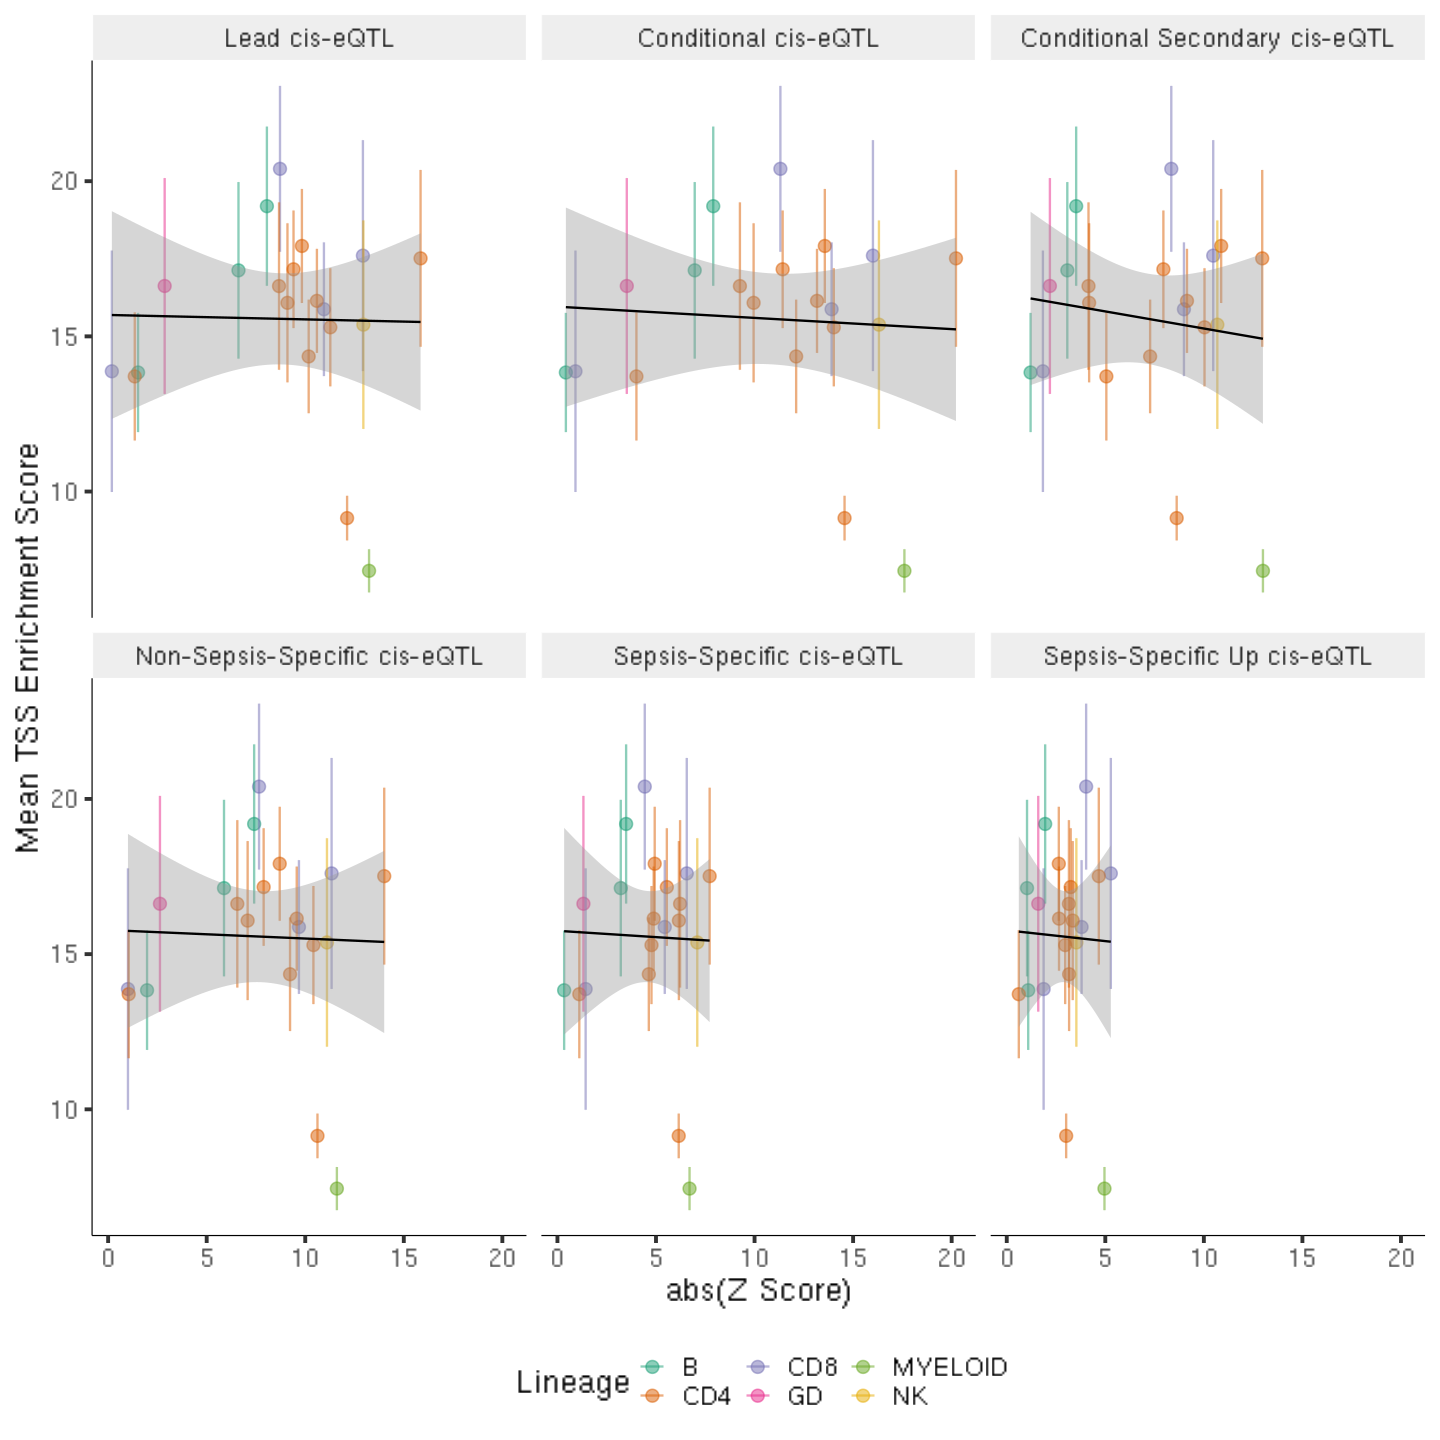

In [27]:
options(repr.plot.width=12, repr.plot.height=12)

merge(effects, p.vals, by=c("SNPs", "Condition")) %>%
    merge(., stat.info, by="SNPs") %>%
    dplyr::mutate(SNPs=factor(SNPs, levels=c("Lead cis-eQTL", "Conditional cis-eQTL", "Conditional Secondary cis-eQTL", "Non-Sepsis-Specific cis-eQTL", "Sepsis-Specific cis-eQTL", "Sepsis-Specific Up cis-eQTL"))) %>%
    dplyr::mutate(Z=abs((Rank.Mean - Mean) / SD)) %>%
    dplyr::mutate(Cell_Type=gsub("-[SU]$", "", Condition)) %>%
    merge(., lineages, by="Cell_Type") %>%
    merge(., sample.qc, by.x="Condition", by.y="condition") %>%
    dplyr::group_by(SNPs, Condition) %>%
    dplyr::summarize(Lineage=Lineage[1], Cell_Type=Cell_Type[1], Z=Z[1], Mean.TSS.Enrichment=mean(tss_enrichment), SE.TSS.Enrichment=sd(tss_enrichment) / sqrt(n()), .groups="drop") %>%
    dplyr::mutate(SE.Low=Mean.TSS.Enrichment - SE.TSS.Enrichment, SE.High=Mean.TSS.Enrichment + SE.TSS.Enrichment) %>%
    ggplot() +
    geom_point(aes(x=Z, y=Mean.TSS.Enrichment, color=Lineage), size=3, alpha=0.5) +
    geom_errorbar(aes(x=Z, ymin=SE.Low, ymax=SE.High, color=Lineage), alpha=0.5) +
    geom_smooth(aes(x=Z, y=Mean.TSS.Enrichment), method="lm", size=0.5, color="black") +
    facet_wrap(. ~ SNPs) +
    scale_color_brewer(palette="Dark2") +
    xlab("abs(Z Score)") + ylab("Mean TSS Enrichment Score") +
    ggplot_theme

## Unstimulated Cell Conditions

### Load Data from Unstimulated Cell Types

In [28]:
lead.effects <- read.table(
    "~/gains_team282/epigenetics/calderon_et_al_hg19/cheers/lead_snps_unstimulated_disease_enrichment_observedMeanRank.txt", 
    col.names=c("Condition", "Rank.Mean")
)
conditional.effects <- read.table(
    "~/gains_team282/epigenetics/calderon_et_al_hg19/cheers/conditional_snps_unstimulated_disease_enrichment_observedMeanRank.txt",
    col.names=c("Condition", "Rank.Mean")
)
conditional.secondary.effects <- read.table(
    "~/gains_team282/epigenetics/calderon_et_al_hg19/cheers/conditional_secondary_snps_unstimulated_disease_enrichment_observedMeanRank.txt",
    col.names=c("Condition", "Rank.Mean")
)
non.sepsis.effects <- read.table(
    "~/gains_team282/epigenetics/calderon_et_al_hg19/cheers/non_sepsis_snps_unstimulated_disease_enrichment_observedMeanRank.txt",
    col.names=c("Condition", "Rank.Mean")
)
sepsis.effects <- read.table(
    "~/gains_team282/epigenetics/calderon_et_al_hg19/cheers/sepsis_snps_unstimulated_disease_enrichment_observedMeanRank.txt", 
    col.names=c("Condition", "Rank.Mean")
)
sepsis.up.effects <- read.table(
    "~/gains_team282/epigenetics/calderon_et_al_hg19/cheers/sepsis_up_snps_unstimulated_disease_enrichment_observedMeanRank.txt",
    col.names=c("Condition", "Rank.Mean")
)

In [29]:
lead.p.vals <- read.table("~/gains_team282/epigenetics/calderon_et_al_hg19/cheers/lead_snps_unstimulated_disease_enrichment_pValues.txt", col.names=c("Condition", "P.Value"))
conditional.p.vals <- read.table("~/gains_team282/epigenetics/calderon_et_al_hg19/cheers/conditional_snps_unstimulated_disease_enrichment_pValues.txt", col.names=c("Condition", "P.Value"))
conditional.secondary.p.vals <- read.table("~/gains_team282/epigenetics/calderon_et_al_hg19/cheers/conditional_secondary_snps_unstimulated_disease_enrichment_pValues.txt", col.names=c("Condition", "P.Value"))
non.sepsis.p.vals <- read.table("~/gains_team282/epigenetics/calderon_et_al_hg19/cheers/non_sepsis_snps_unstimulated_disease_enrichment_pValues.txt", col.names=c("Condition", "P.Value"))
sepsis.p.vals <- read.table("~/gains_team282/epigenetics/calderon_et_al_hg19/cheers/sepsis_snps_unstimulated_disease_enrichment_pValues.txt", col.names=c("Condition", "P.Value"))
sepsis.up.p.vals <- read.table("~/gains_team282/epigenetics/calderon_et_al_hg19/cheers/sepsis_up_snps_unstimulated_disease_enrichment_pValues.txt", col.names=c("Condition", "P.Value"))

In [30]:
lead.summary <- read.table("~/gains_team282/epigenetics/calderon_et_al_hg19/cheers/lead_snps_unstimulated.log", sep="\t")
conditional.summary <- read.table("~/gains_team282/epigenetics/calderon_et_al_hg19/cheers/conditional_snps_unstimulated.log", sep="\t")
conditional.secondary.summary <- read.table("~/gains_team282/epigenetics/calderon_et_al_hg19/cheers/conditional_secondary_snps_unstimulated.log", sep="\t")
non.sepsis.summary <- read.table("~/gains_team282/epigenetics/calderon_et_al_hg19/cheers/non_sepsis_snps_unstimulated.log", sep="\t")
sepsis.summary <- read.table("~/gains_team282/epigenetics/calderon_et_al_hg19/cheers/sepsis_snps_unstimulated.log", sep="\t")
sepsis.up.summary <- read.table("~/gains_team282/epigenetics/calderon_et_al_hg19/cheers/sepsis_up_snps_unstimulated.log", sep="\t")

In [31]:
stat.info <- data.frame(
    SNPs=c("Lead cis-eQTL", "Conditional cis-eQTL", "Conditional Secondary cis-eQTL", "Non-Sepsis-Specific cis-eQTL", "Sepsis-Specific cis-eQTL", "Sepsis-Specific Up cis-eQTL"),
    Mean=c(lead.summary[4,2], conditional.summary[4,2], conditional.secondary.summary[4,2], non.sepsis.summary[4,2], sepsis.summary[4,2], sepsis.up.summary[4,2]),
    SD=c(lead.summary[5,2], conditional.summary[5,2], conditional.secondary.summary[5,2], non.sepsis.summary[5,2], sepsis.summary[5,2], sepsis.up.summary[5,2])
)

head(stat.info)

,SNPs,Mean,SD
,<chr>,<dbl>,<dbl>
1,Lead cis-eQTL,361495.5,3760.069
2,Conditional cis-eQTL,361495.5,3122.375
3,Conditional Secondary cis-eQTL,361495.5,5321.861
4,Non-Sepsis-Specific cis-eQTL,361495.5,4231.269
5,Sepsis-Specific cis-eQTL,361495.5,8063.141
6,Sepsis-Specific Up cis-eQTL,361495.5,12562.820


In [32]:
effects <- dplyr::bind_rows(
    lead.effects %>% dplyr::mutate(SNPs="Lead cis-eQTL"),
    conditional.effects %>% dplyr::mutate(SNPs="Conditional cis-eQTL"),
    conditional.secondary.effects %>% dplyr::mutate(SNPs="Conditional Secondary cis-eQTL"),
    non.sepsis.effects %>% dplyr::mutate(SNPs="Non-Sepsis-Specific cis-eQTL"),
    sepsis.effects %>% dplyr::mutate(SNPs="Sepsis-Specific cis-eQTL"),
    sepsis.up.effects %>% dplyr::mutate(SNPs="Sepsis-Specific Up cis-eQTL")
)

head(effects)

,Condition,Rank.Mean,SNPs
,<chr>,<dbl>,<chr>
1,Bulk_B-U,348539.6,Lead cis-eQTL
2,CD8pos_T-U,351820.9,Lead cis-eQTL
3,Central_memory_CD8pos_T-U,358722.6,Lead cis-eQTL
4,Effector_CD4pos_T-U,354915.8,Lead cis-eQTL
5,Effector_memory_CD8pos_T-U,331177.3,Lead cis-eQTL
6,Follicular_T_Helper-U,366086.1,Lead cis-eQTL


In [33]:
p.vals <- dplyr::bind_rows(
    lead.p.vals %>% dplyr::mutate(SNPs="Lead cis-eQTL"),
    conditional.p.vals %>% dplyr::mutate(SNPs="Conditional cis-eQTL"),
    conditional.secondary.p.vals %>% dplyr::mutate(SNPs="Conditional Secondary cis-eQTL"),
    non.sepsis.p.vals %>% dplyr::mutate(SNPs="Non-Sepsis-Specific cis-eQTL"),
    sepsis.p.vals %>% dplyr::mutate(SNPs="Sepsis-Specific cis-eQTL"),
    sepsis.up.p.vals %>% dplyr::mutate(SNPs="Sepsis-Specific Up cis-eQTL")
)

head(p.vals)

,Condition,P.Value,SNPs
,<chr>,<dbl>,<chr>
1,Bulk_B-U,0.9997152,Lead cis-eQTL
2,CD8pos_T-U,0.9949586,Lead cis-eQTL
3,Central_memory_CD8pos_T-U,0.7695752,Lead cis-eQTL
4,Effector_CD4pos_T-U,0.9599316,Lead cis-eQTL
5,Effector_memory_CD8pos_T-U,1.0000000,Lead cis-eQTL
6,Follicular_T_Helper-U,0.1110674,Lead cis-eQTL


### Enrichment of Different SNP Lists

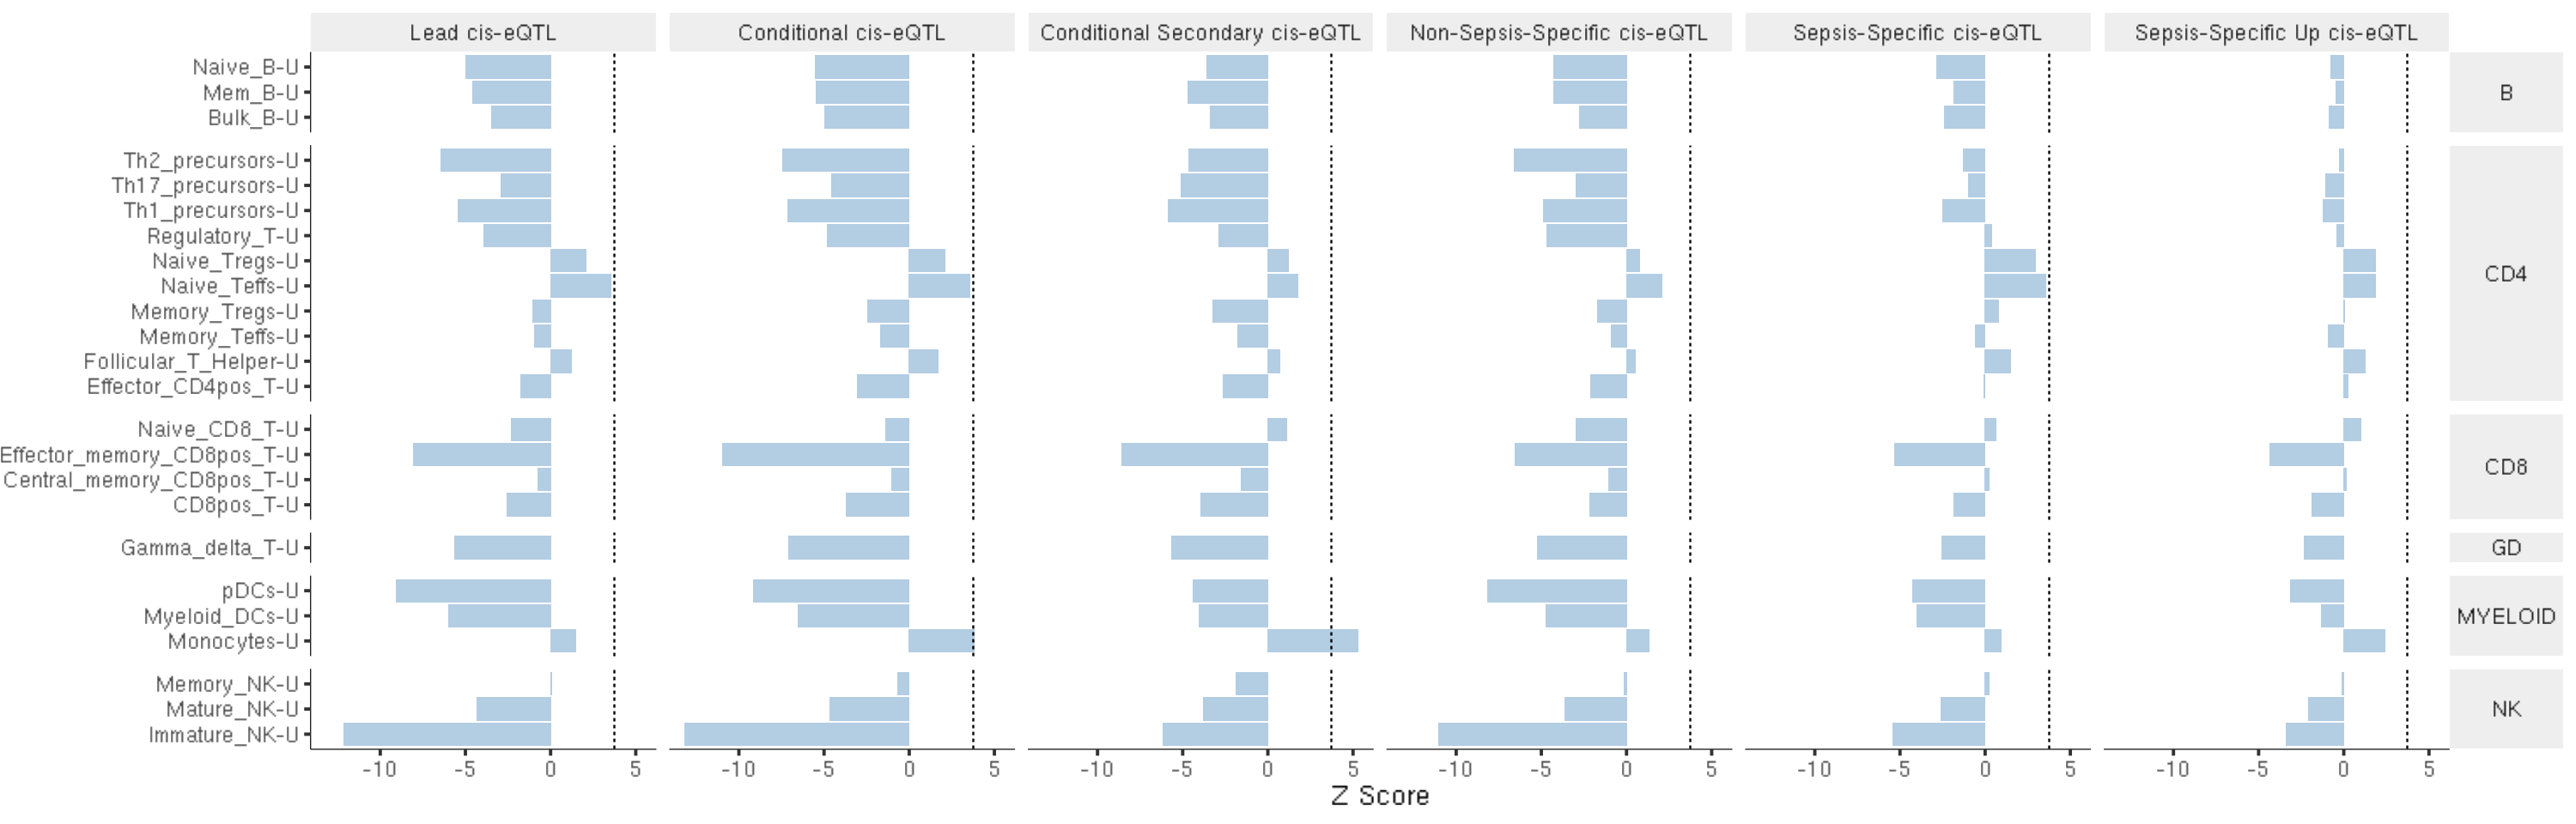

In [34]:
options(repr.plot.width=25, repr.plot.height=8)

merge(effects, p.vals, by=c("SNPs", "Condition")) %>%
    merge(., stat.info, by="SNPs") %>%
    dplyr::mutate(SNPs=factor(SNPs, levels=c("Lead cis-eQTL", "Conditional cis-eQTL", "Conditional Secondary cis-eQTL", "Non-Sepsis-Specific cis-eQTL", "Sepsis-Specific cis-eQTL", "Sepsis-Specific Up cis-eQTL"))) %>%
    dplyr::mutate(Z=(Rank.Mean - Mean) / SD) %>%
    dplyr::mutate(Cell_Type=gsub("-[SU]$", "", Condition)) %>%
    merge(., lineages, by="Cell_Type") %>%
    ggplot() + 
    geom_bar(aes(x=Condition, y=Z), stat="identity", fill=RColorBrewer::brewer.pal(n=3, name="Pastel1")[2]) +
    geom_hline(aes(yintercept=critical.value), lty=2) +
    facet_grid(Lineage ~ SNPs, scale="free_y", space="free_y") +
    coord_flip() +
    ylab("Z Score") +
    ggplot_theme +
    theme(axis.title.y=element_blank(), strip.text.y=element_text(angle=0))

ggsave("03_Functional_Interpretation/results/cheers_hg19_calderon_et_al_unstimulated_all.svg", width=25, height=8)

### Enrichment of Secondary cis-eQTL

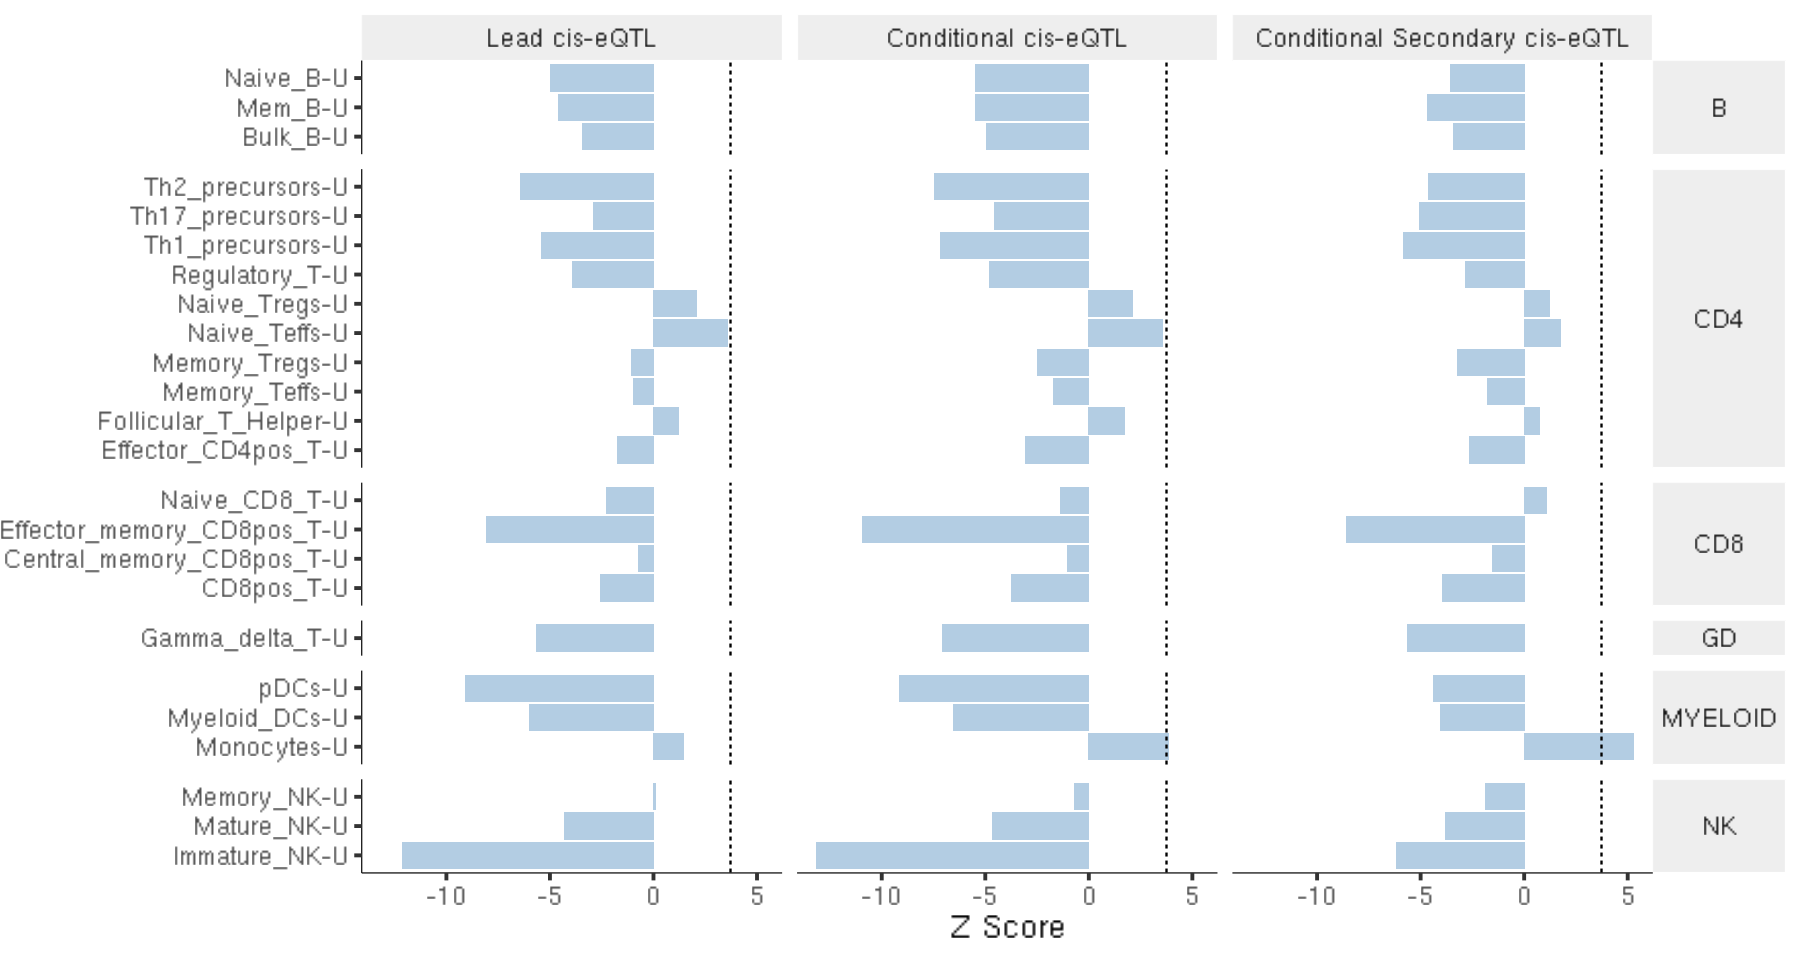

In [35]:
options(repr.plot.width=15, repr.plot.height=8)

merge(effects, p.vals, by=c("SNPs", "Condition")) %>%
    merge(., stat.info, by="SNPs") %>%
    dplyr::mutate(SNPs=factor(SNPs, levels=c("Lead cis-eQTL", "Conditional cis-eQTL", "Conditional Secondary cis-eQTL"))) %>%
    dplyr::filter(SNPs %in% c("Lead cis-eQTL", "Conditional cis-eQTL", "Conditional Secondary cis-eQTL")) %>%
    dplyr::mutate(Z=(Rank.Mean - Mean) / SD) %>%
    dplyr::mutate(Cell_Type=gsub("-[SU]$", "", Condition)) %>%
    merge(., lineages, by="Cell_Type") %>%
    ggplot() + 
    geom_bar(aes(x=Condition, y=Z), stat="identity", fill=RColorBrewer::brewer.pal(n=3, name="Pastel1")[2]) +
    geom_hline(aes(yintercept=critical.value), lty=2) +
    facet_grid(Lineage ~ SNPs, scale="free_y", space="free_y") +
    coord_flip() +
    ylab("Z Score") +
    ggplot_theme +
    theme(axis.title.y=element_blank(), strip.text.y=element_text(angle=0))

ggsave("03_Functional_Interpretation/results/cheers_hg19_calderon_et_al_unstimulated_secondary_signals.svg", width=15, height=8)

### Enrichment of Sepsis-Specific cis-eQTL

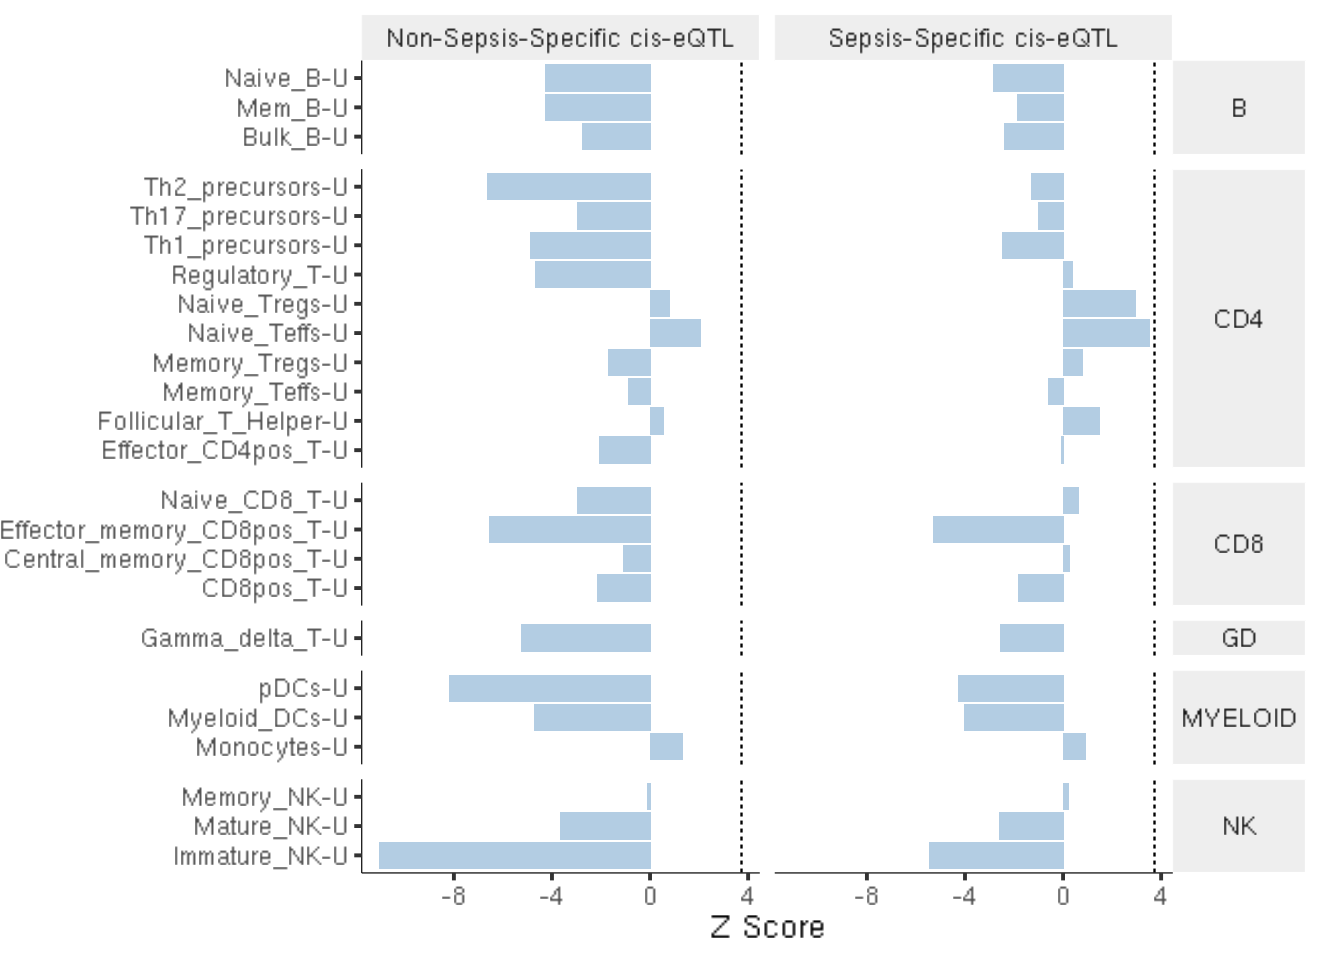

In [37]:
options(repr.plot.width=11, repr.plot.height=8)

merge(effects, p.vals, by=c("SNPs", "Condition")) %>%
    merge(., stat.info, by="SNPs") %>%
    dplyr::filter(SNPs %in% c("Sepsis-Specific cis-eQTL", "Non-Sepsis-Specific cis-eQTL")) %>%
    dplyr::mutate(Z=(Rank.Mean - Mean) / SD) %>%
    dplyr::mutate(Cell_Type=gsub("-[SU]$", "", Condition)) %>%
    merge(., lineages, by="Cell_Type") %>%
    ggplot() + 
    geom_bar(aes(x=Condition, y=Z), stat="identity", fill=RColorBrewer::brewer.pal(n=3, name="Pastel1")[2]) +
    geom_hline(aes(yintercept=critical.value), lty=2) +
    facet_grid(Lineage ~ SNPs, scale="free_y", space="free_y") +
    coord_flip() +
    ylab("Z Score") +
    ggplot_theme +
    theme(axis.title.y=element_blank(), strip.text.y=element_text(angle=0))

ggsave("03_Functional_Interpretation/results/cheers_hg19_calderon_et_al_unstimulated_sepsis_specific.svg", width=11, height=8)

# Signal Association with ATAC-Seq Sample Quality

Since the pattern is repeated across various SNP lists, the sample quality of the ATAC-Seq samples may make it more likely for certain associations to come through because more peaks are being detected in those samples. Indeed, in my own processing of the data, I have noticed that sample quality is associated with specific cell types.

In [38]:
sample.qc <- readxl::read_xlsx("03_Functional_Interpretation/data/41588_2019_505_MOESM3_ESM.xlsx", sheet="ATAC-seq samle QC") %>%
    dplyr::mutate(condition=paste0(cell_type, "-", condition))

In [39]:
head(sample.qc)

sample,n_peaks,merged_final_read_count,tss_enrichment,donor,cell_type,condition
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
1001-Bulk_B-S,99921,89133710,22.60328,1001,Bulk_B,Bulk_B-S
1001-Bulk_B-U,89186,75096300,21.60695,1001,Bulk_B,Bulk_B-U
1001-CD8pos_T-S,99319,79127056,19.86049,1001,CD8pos_T,CD8pos_T-S
1001-CD8pos_T-U,79809,83412526,21.93009,1001,CD8pos_T,CD8pos_T-U
1001-Central_memory_CD8pos_T-S,100868,56264624,18.59552,1001,Central_memory_CD8pos_T,Central_memory_CD8pos_T-S
1001-Central_memory_CD8pos_T-U,72386,54006014,22.54937,1001,Central_memory_CD8pos_T,Central_memory_CD8pos_T-U


`geom_smooth()` using formula 'y ~ x'



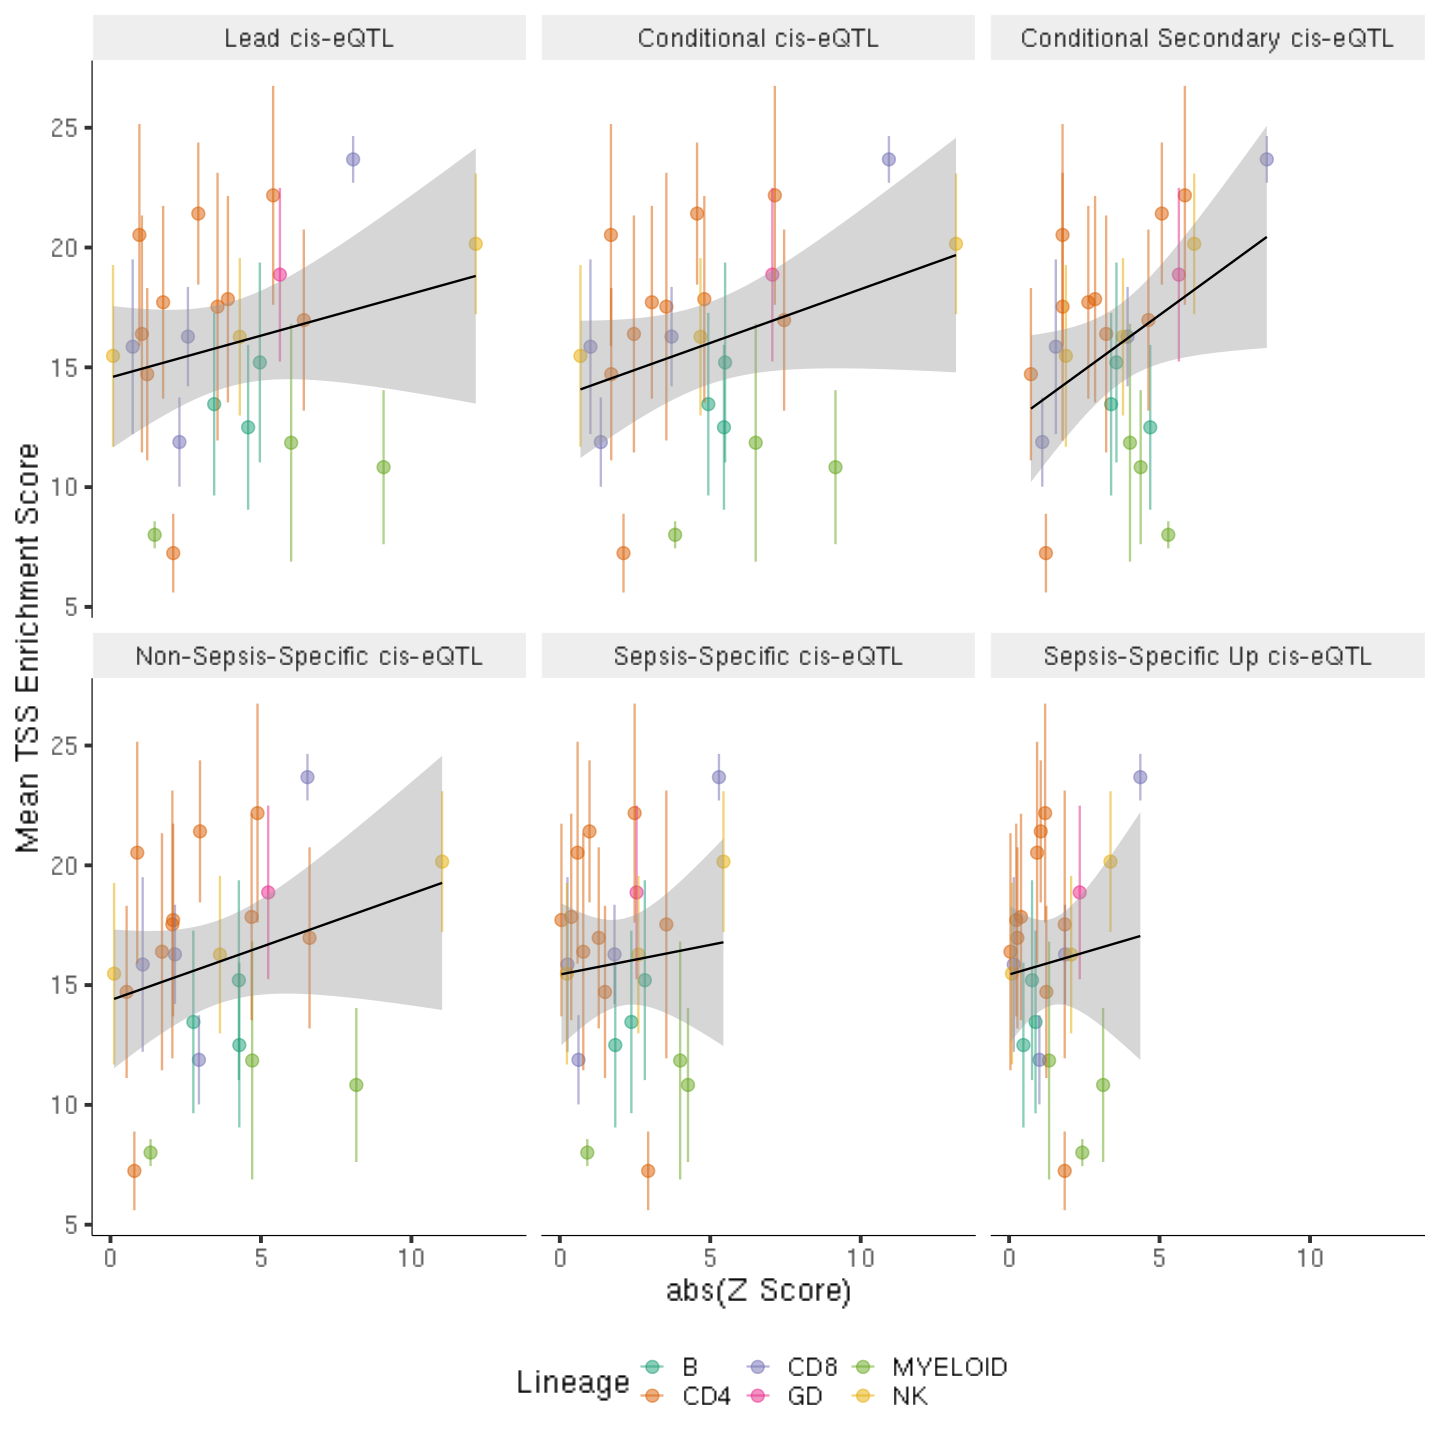

In [40]:
options(repr.plot.width=12, repr.plot.height=12)

merge(effects, p.vals, by=c("SNPs", "Condition")) %>%
    merge(., stat.info, by="SNPs") %>%
    dplyr::mutate(SNPs=factor(SNPs, levels=c("Lead cis-eQTL", "Conditional cis-eQTL", "Conditional Secondary cis-eQTL", "Non-Sepsis-Specific cis-eQTL", "Sepsis-Specific cis-eQTL", "Sepsis-Specific Up cis-eQTL"))) %>%
    dplyr::mutate(Z=abs((Rank.Mean - Mean) / SD)) %>%
    dplyr::mutate(Cell_Type=gsub("-[SU]$", "", Condition)) %>%
    merge(., lineages, by="Cell_Type") %>%
    merge(., sample.qc, by.x="Condition", by.y="condition") %>%
    dplyr::group_by(SNPs, Condition) %>%
    dplyr::summarize(Lineage=Lineage[1], Cell_Type=Cell_Type[1], Z=Z[1], Mean.TSS.Enrichment=mean(tss_enrichment), SE.TSS.Enrichment=sd(tss_enrichment) / sqrt(n()), .groups="drop") %>%
    dplyr::mutate(SE.Low=Mean.TSS.Enrichment - SE.TSS.Enrichment, SE.High=Mean.TSS.Enrichment + SE.TSS.Enrichment) %>%
    ggplot() +
    geom_point(aes(x=Z, y=Mean.TSS.Enrichment, color=Lineage), size=3, alpha=0.5) +
    geom_errorbar(aes(x=Z, ymin=SE.Low, ymax=SE.High, color=Lineage), alpha=0.5) +
    geom_smooth(aes(x=Z, y=Mean.TSS.Enrichment), method="lm", size=0.5, color="black") +
    facet_wrap(. ~ SNPs) +
    scale_color_brewer(palette="Dark2") +
    xlab("abs(Z Score)") + ylab("Mean TSS Enrichment Score") +
    ggplot_theme

## Peaks Driving Cell-Type-Specific Enrichment

CHEERS works on cell-type-specificity scores for peaks. We can use these specificity scores to understand which peaks are driving the enrichment signal.

In [4]:
all.norm <- fread("~/gains_team282/epigenetics/calderon_et_al_hg19/cheers/normalized/Calderon_et_al_counts_normToMax_quantileNorm_euclideanNorm.txt") %>%
    as.data.frame() %>%
    dplyr::mutate(ID=paste0(chr, ":", start, "-", end))

rownames(all.norm) <- all.norm$ID

In [19]:
head(all.norm)

,chr,start,end,Bulk_B-S,Bulk_B-U,CD8pos_T-S,CD8pos_T-U,Central_memory_CD8pos_T-S,Central_memory_CD8pos_T-U,Effector_CD4pos_T-S,⋯,Plasmablasts-U,Regulatory_T-S,Regulatory_T-U,Th17_precursors-S,Th17_precursors-U,Th1_precursors-S,Th1_precursors-U,Th2_precursors-S,Th2_precursors-U,ID
,<chr>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
chr1:10045-10517,chr1,10045,10517,0.1765,0.1319,0.1012,0.1678,0.0899,0.1889,0.1041,⋯,0.1387,0.2248,0.1779,0.1107,0.2058,0.1177,0.1378,0.1042,0.1481,chr1:10045-10517
chr1:237698-237812,chr1,237698,237812,0.1676,0.1268,0.1465,0.1292,0.1336,0.1017,0.2376,⋯,0.2402,0.1560,0.1036,0.1694,0.1967,0.1789,0.0577,0.1621,0.1001,chr1:237698-237812
chr1:540672-541256,chr1,540672,541256,0.0859,0.0737,0.1875,0.2144,0.2274,0.1416,0.1394,⋯,0.0190,0.1146,0.0536,0.1383,0.1505,0.1313,0.1567,0.0795,0.0745,chr1:540672-541256
chr1:564524-564725,chr1,564524,564725,0.0009,0.1506,0.0575,0.1072,0.1040,0.1410,0.0004,⋯,0.0003,0.1296,0.1676,0.0722,0.1506,0.0861,0.0904,0.1433,0.1232,chr1:564524-564725
chr1:567099-567618,chr1,567099,567618,0.1198,0.1387,0.2099,0.0731,0.3071,0.0492,0.1163,⋯,0.0046,0.3124,0.1813,0.0832,0.0188,0.0686,0.0898,0.1939,0.0679,chr1:567099-567618
chr1:569577-570156,chr1,569577,570156,0.0969,0.1721,0.1548,0.0893,0.1819,0.0989,0.1528,⋯,0.2060,0.1894,0.1379,0.1166,0.0914,0.1294,0.0931,0.2060,0.1019,chr1:569577-570156


In [24]:
plot.data <- all.norm %>%
    tidyr::gather("Condition", "Euclidean.Norm", -ID, -chr, -start, -end) %>%
    dplyr::mutate(Stimulated = ifelse(grepl("-S$", Condition), "Yes", "No")) %>%
    dplyr::mutate(Peak.Size = end - start)

In [ ]:
plot.data %>%
    ggplot() +
    geom_point(aes(x=Peak.Size, y=Euclidean.Norm, color=Stimulated)) +
    ggplot_theme

`geom_smooth()` using method = 'gam' and formula 'y ~ s(x, bs = "cs")'



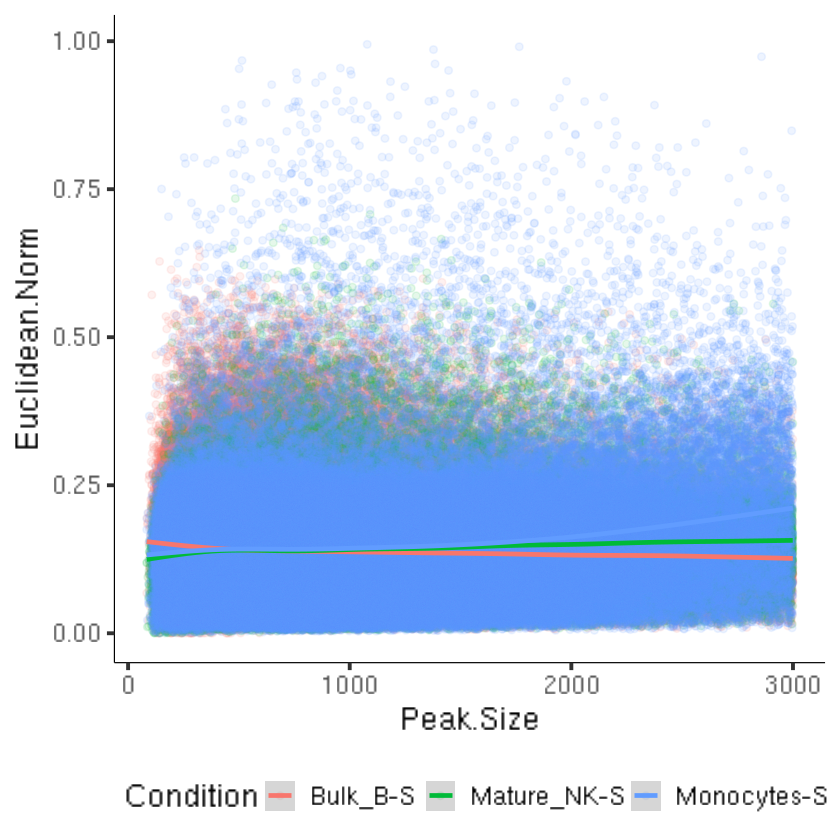

In [6]:
all.norm %>%
    tidyr::gather("Condition", "Euclidean.Norm", -ID, -chr, -start, -end) %>%
    dplyr::filter(Condition == "Bulk_B-S" | Condition == "Monocytes-S" | Condition == "Mature_NK-S") %>%
    dplyr::mutate(Peak.Size = end - start) %>%
    dplyr::mutate(Decile = factor(dplyr::ntile(Peak.Size, 100))) %>%
    ggplot(aes(color=Condition)) +
    geom_point(aes(x=Peak.Size, y=Euclidean.Norm), alpha=0.1) +
    geom_smooth(aes(x=Peak.Size, y=Euclidean.Norm)) +
    ggplot_theme

In [41]:
stimulated.norm <- stimulated.norm %>%
    dplyr::select(everything(), -chr, -start, -end, -ID) %>%
    apply(., 2, function(x) { rank(x, ties.method="min") })

In [42]:
non.sepsis.overlaps <- read.table("~/gains_team282/epigenetics/calderon_et_al_hg19/cheers/non_sepsis_snps_stimulated_SNPsOverlappingPeaks.txt", sep="\t", header=TRUE)

sepsis.overlaps <- read.table("~/gains_team282/epigenetics/calderon_et_al_hg19/cheers/sepsis_snps_stimulated_SNPsOverlappingPeaks.txt", sep="\t", header=TRUE)

In [43]:
peak.ids <- with(sepsis.overlaps, paste0(chr, ":", start, "-", end))
rank.data <- stimulated.norm[peak.ids,] / mean(stimulated.norm)
percentile.90th <- quantile(apply(rank.data, 1, max), probs=c(0.9))
sepsis.peak.ids <- rownames(rank.data)[apply(rank.data, 1, max) > percentile.90th]

In [44]:
peak.ids <- with(non.sepsis.overlaps, paste0(chr, ":", start, "-", end))
rank.data <- stimulated.norm[peak.ids,] / mean(stimulated.norm)
percentile.90th <- quantile(apply(rank.data, 1, max), probs=c(0.9))
non.sepsis.peak.ids <- rownames(rank.data)[apply(rank.data, 1, max) > percentile.90th]

In [45]:
peak.ids <- sort(union(sepsis.peak.ids, non.sepsis.peak.ids))
plot.data <- stimulated.norm[peak.ids,] / mean(stimulated.norm)

'magick' package is suggested to install to give better rasterization.

Set `ht_opt$message = FALSE` to turn off this message.



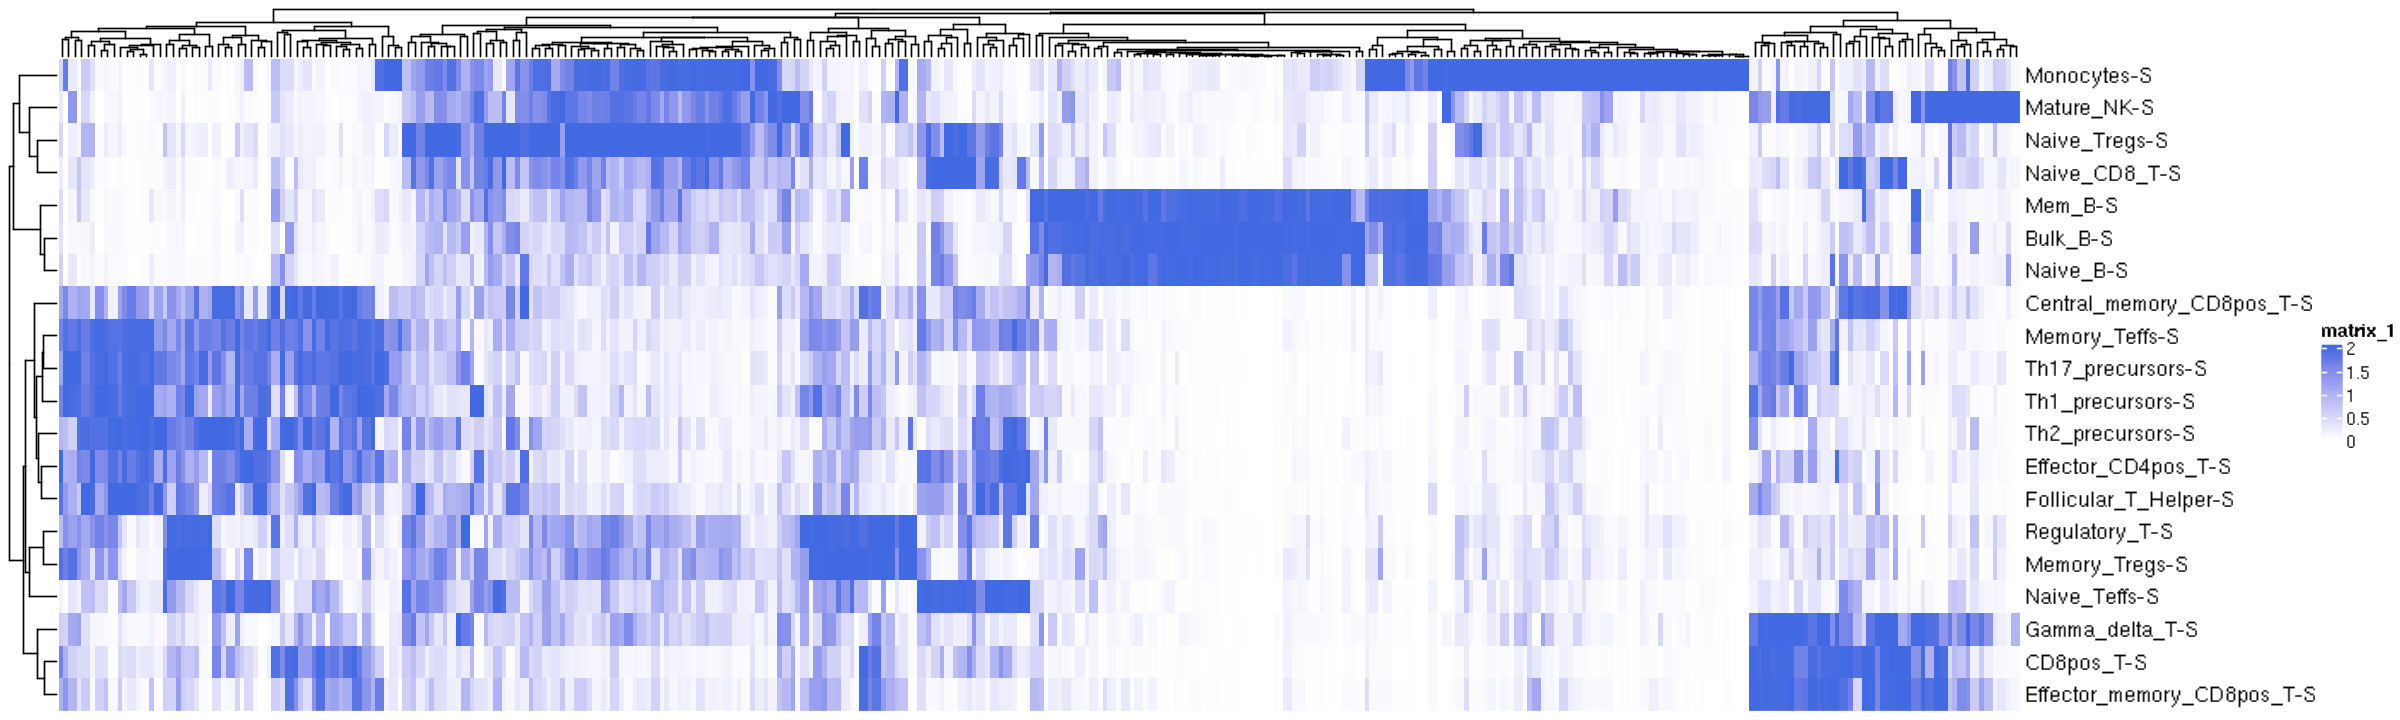

In [46]:
options(repr.plot.width=20, repr.plot.height=6)

col_fun = circlize::colorRamp2(c(0, 2), c("white", "royalblue"))
Heatmap(t(plot.data), col=col_fun, show_column_names=F, use_raster=TRUE)